#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload

In [2]:
# Custom imports and styles
import utils
import eda_utils
import model_utils

In [3]:
reload(model_utils);

In [4]:
plt.style.use('./styles.txt')

#### Index

1. [Introduction](#intro)<br>
2. [Data Loading and Cleaning](#dl)<br>
3. [Creating Additional Features](#features)<br>
    3.1 [Saving the DataFrame](#saving)<br>
4. [Preprocessing](#pp)<br>
    4.1 [Preprocessing Categorical Data](#pp_cat)<br>
    4.2 [Preprocessing Numerical Data](#pp_num)<br>
5. [Exploring the Relationships Between Variables](#relationships)<br>
6. [Baseline Linear Regression](#base_linreg)<br>
    6.1 [Preparation](#prep)<br>
    6.2 [Model Building](#model_building)<br>
    6.3 [Baseline Model Evaluation](#evaluation)<br>
    6.4 [Model Improvement](#improvement)<br>
7. [Baseline Logistic Regression](#base_logreg)<br>


---
<a id='intro'></a>
# Introduction

**TODO**

---
<a id='dl'></a>
## Data Loading and Cleaning

In [5]:
# Load data
df_raw = pd.read_pickle('sample_data/30k_wildfires_weather_emissions.pkl')

In [6]:
df_raw.drop('index', axis=1, inplace=True)
df_raw.head(2)

DATE  FIRE_YEAR  DISCOVERY_DOY  FIRE_SIZE FIRE_SIZE_CLASS  LATITUDE  \
0 1992-01-01       1992              1        0.1               A   43.3250   
1 1992-01-01       1992              1        3.0               B   33.0634   

    LONGITUDE STATE                                     tempmax  avg_tempmax  \
0 -101.018500    SD         [6.7, 6.7, 1.7, 7.2, 8.4, 1.7, 4.4]     5.257143   
1  -90.120813    MS  [16.7, 13.4, 10.7, 11.7, 12.2, 10.7, 15.7]    13.014286   

   ...   avg_dew                                   windspeed avg_windspeed  \
0  ... -6.071429  [13.0, 22.3, 31.7, 20.5, 11.2, 18.7, 11.2]     18.371429   
1  ...  3.771429  [14.8, 18.4, 14.8, 14.8, 18.4, 22.3, 11.2]     16.385714   

                                             winddir avg_winddir  \
0  [295.9, 179.8, 186.4, 218.7, 263.2, 173.2, 247.3]       223.5   
1        [25.9, 46.9, 303.3, 10.4, 29.3, 36.9, 70.2]        74.7   

                                            pressure avg_pressure  \
0  [1026.9, 1029.2, 1017.7, 1012.2, 1019.1, 1024....  1021.671429   
1  [1023.4, 1023.0, 1019.5, 1020.8, 1024.5, 1027....  1023.442857   

            ch4           co2           n2o  
0  4.613353e-11  3.672947e-09  3.926278e-12  
1  1.679468e-11  3.891437e-09  1.957145e-12  

[2 rows x 27 columns]

In [7]:
eda_utils.BasicEda(df_raw, 'Extended Wildfire Data', ['shape', 'null', 'columns', 'dtypes'])

EXTENDED WILDFIRE DATA
----------------------

Rows: 30000    Columns: 27

Total null rows: 0
Percentage null rows:  0.000%

DATE               datetime64[ns]
FIRE_YEAR                   int64
DISCOVERY_DOY               int64
FIRE_SIZE                 float64
FIRE_SIZE_CLASS            object
LATITUDE                  float64
LONGITUDE                 float64
STATE                      object
tempmax                    object
avg_tempmax               float64
temp                       object
avg_temp                  float64
humidity                   object
avg_humidity              float64
precip                     object
avg_precip                float64
dew                        object
avg_dew                   float64
windspeed                  object
avg_windspeed             float64
winddir                    object
avg_winddir               float64
pressure                   object
avg_pressure              float64
ch4                       float64
co2                      

In [8]:
df_raw.isna().sum()

DATE                  0
FIRE_YEAR             0
DISCOVERY_DOY         0
FIRE_SIZE             0
FIRE_SIZE_CLASS       0
LATITUDE              0
LONGITUDE             0
STATE                 0
tempmax               0
avg_tempmax           2
temp                  0
avg_temp            947
humidity              0
avg_humidity       1004
precip                0
avg_precip         4354
dew                   0
avg_dew            1004
windspeed             0
avg_windspeed       940
winddir               0
avg_winddir        4144
pressure              0
avg_pressure       3594
ch4                   0
co2                   0
n2o                   0
dtype: int64

Assume they can't be imputed, we will remove all of them, however accounted for this by loading a large enough sample that we are left with a good amount of values.

Get the indexes of all the null values to see how much data we would lose.

In [9]:
cumulative_cols = ['tempmax', 'temp', 'humidity', 'precip', 'dew', 'winddir', 'pressure']

indexes = []

for index, row in df_raw.iterrows():
    for col in cumulative_cols:
        if True in np.isnan(row[col]):
            indexes.append(index)
            break
            
print(len(indexes))

9149


Unfortunately, we see that we will be removing approximately 29% of our data, however we knew that this would happen which is why we created a large sample from which to work from. We will therefore remove these values.

In [10]:
# Drop these indexes from our data
df_raw.drop(index=indexes, inplace=True)

In [11]:
df_raw.isna().sum()

DATE               0
FIRE_YEAR          0
DISCOVERY_DOY      0
FIRE_SIZE          0
FIRE_SIZE_CLASS    0
LATITUDE           0
LONGITUDE          0
STATE              0
tempmax            0
avg_tempmax        0
temp               0
avg_temp           0
humidity           0
avg_humidity       0
precip             0
avg_precip         0
dew                0
avg_dew            0
windspeed          0
avg_windspeed      0
winddir            0
avg_winddir        0
pressure           0
avg_pressure       0
ch4                0
co2                0
n2o                0
dtype: int64

In [12]:
df_raw.shape

(20851, 27)

In [13]:
df_cleaned = df_raw.copy()

---
<a id='features'></a>
## Creating Additional Features

One of the main reasons that we included the list within the DataFrame was to allow us to create new features from the weather information without having to collect data through the API again. one of the variables that we are able to create is the variance for each of the weather points. The variance will hopefully indicate how significantly the weather changed in the days prior to the wildfire.

In [14]:
week_data = [
    'tempmax',
    'temp',
    'humidity',
    'precip',
    'dew',
    'windspeed',
    'winddir',
    'pressure'
]

In [15]:
for metric in week_data:
    variance_col_name = f'{metric}_variance'
    df_cleaned[variance_col_name] = df_cleaned[metric].apply(lambda x: np.var(x))
    
    delta_col_name = f'{metric}_delta'
    df_cleaned[delta_col_name] = df_cleaned[metric].apply(lambda x: x[-1] - x[0])

In [16]:
df_cleaned.head()

DATE  FIRE_YEAR  DISCOVERY_DOY  FIRE_SIZE FIRE_SIZE_CLASS   LATITUDE  \
0 1992-01-01       1992              1       0.10               A  43.325000   
2 1992-01-01       1992              1       1.00               B  33.058333   
3 1992-01-02       1992              2       0.25               A  40.775000   
5 1992-01-03       1992              3       1.91               B  31.018500   
6 1992-01-03       1992              3       2.00               B  30.728900   

    LONGITUDE STATE                                     tempmax  avg_tempmax  \
0 -101.018500    SD         [6.7, 6.7, 1.7, 7.2, 8.4, 1.7, 4.4]     5.257143   
2  -79.979167    SC  [10.8, 11.2, 16.0, 15.9, 13.9, 12.6, 15.5]    13.700000   
3  -74.854160    NJ         [7.8, 8.0, 7.5, 6.4, 2.3, 5.0, 7.7]     6.385714   
5  -83.297300    GA   [15.1, 15.6, 9.8, 16.0, 13.2, 16.7, 14.8]    14.457143   
6  -87.238100    FL  [16.9, 12.6, 11.6, 14.9, 14.7, 15.9, 14.4]    14.428571   

   ... precip_variance  precip_delta dew_variance  dew_delta  \
0  ...        0.000000          0.00     5.399184        3.5   
2  ...       55.589796         -4.40     7.196327        0.1   
3  ...        9.546510          0.00    19.731020        4.0   
5  ...       59.321224         -9.70     9.142041       -4.1   
6  ...        0.213355         -1.32    10.262857       -7.9   

  windspeed_variance  windspeed_delta winddir_variance  winddir_delta  \
0          47.062041             -1.8      1889.074286          -48.6   
2           5.575510              2.0     15648.559592          -14.9   
3          34.516735            -10.6     16492.948163         -254.6   
5          11.228571              0.2     16679.204898          223.6   
6          27.382857              6.7     19587.093469          -24.8   

  pressure_variance  pressure_delta  
0         28.913469            -4.3  
2         19.071020             2.4  
3         75.711429            -0.9  
5         21.585306            -8.4  
6         13.107755            -2.7  

[5 rows x 43 columns]

In [17]:
# Sanity check to make sure that we have no null values in the data set
df_cleaned.isna().sum()

DATE                  0
FIRE_YEAR             0
DISCOVERY_DOY         0
FIRE_SIZE             0
FIRE_SIZE_CLASS       0
LATITUDE              0
LONGITUDE             0
STATE                 0
tempmax               0
avg_tempmax           0
temp                  0
avg_temp              0
humidity              0
avg_humidity          0
precip                0
avg_precip            0
dew                   0
avg_dew               0
windspeed             0
avg_windspeed         0
winddir               0
avg_winddir           0
pressure              0
avg_pressure          0
ch4                   0
co2                   0
n2o                   0
tempmax_variance      0
tempmax_delta         0
temp_variance         0
temp_delta            0
humidity_variance     0
humidity_delta        0
precip_variance       0
precip_delta          0
dew_variance          0
dew_delta             0
windspeed_variance    0
windspeed_delta       0
winddir_variance      0
winddir_delta         0
pressure_varianc

In [18]:
# Check duplicate values
df_cleaned.drop(week_data, axis=1).duplicated().sum()

0

In [19]:
df_cleaned.drop(week_data, axis=1, inplace=True)

In [20]:
df_cleaned.reset_index(drop=True, inplace=True)

<a id='saving'></a>
#### Saving the DataFrame

In [21]:
# df_cleaned.to_pickle('sample_data/30k_engineered.pkl')

---
<a id='pp'></a>
## Preprocessing

First, we will separate into *numeric* and *categorical* columns, working on these individually and eventually combining them.

In [24]:
numeric_df = df_cleaned.select_dtypes('number').copy()
categorical_df = df_cleaned.select_dtypes('object').copy()

In [25]:
print("Numeric columns: \n", ',\n '.join(numeric_df.columns))
print("")
print("Categorical columns: \n", ', \n '.join(categorical_df.columns))

Numeric columns: 
 FIRE_YEAR,
 DISCOVERY_DOY,
 FIRE_SIZE,
 LATITUDE,
 LONGITUDE,
 avg_tempmax,
 avg_temp,
 avg_humidity,
 avg_precip,
 avg_dew,
 avg_windspeed,
 avg_winddir,
 avg_pressure,
 ch4,
 co2,
 n2o,
 tempmax_variance,
 tempmax_delta,
 temp_variance,
 temp_delta,
 humidity_variance,
 humidity_delta,
 precip_variance,
 precip_delta,
 dew_variance,
 dew_delta,
 windspeed_variance,
 windspeed_delta,
 winddir_variance,
 winddir_delta,
 pressure_variance,
 pressure_delta

Categorical columns: 
 FIRE_SIZE_CLASS, 
 STATE


In [26]:
numeric_df.head()

FIRE_YEAR  DISCOVERY_DOY  FIRE_SIZE   LATITUDE   LONGITUDE  avg_tempmax  \
0       1992              1       0.10  43.325000 -101.018500     5.257143   
1       1992              1       1.00  33.058333  -79.979167    13.700000   
2       1992              2       0.25  40.775000  -74.854160     6.385714   
3       1992              3       1.91  31.018500  -83.297300    14.457143   
4       1992              3       2.00  30.728900  -87.238100    14.428571   

    avg_temp  avg_humidity  avg_precip   avg_dew  ...  precip_variance  \
0  -2.928571     81.142857    0.000000 -6.071429  ...         0.000000   
1   9.885714     81.428571    4.185714  6.671429  ...        55.589796   
2   1.585714     67.185714    1.394286 -4.242857  ...         9.546510   
3  11.828571     78.957143    4.685714  8.128571  ...        59.321224   
4  10.985714     79.971429    0.188571  7.500000  ...         0.213355   

   precip_delta  dew_variance  dew_delta  windspeed_variance  windspeed_delta  \
0          0.00      5.399184        3.5           47.062041             -1.8   
1         -4.40      7.196327        0.1            5.575510              2.0   
2          0.00     19.731020        4.0           34.516735            -10.6   
3         -9.70      9.142041       -4.1           11.228571              0.2   
4         -1.32     10.262857       -7.9           27.382857              6.7   

   winddir_variance  winddir_delta  pressure_variance  pressure_delta  
0       1889.074286          -48.6          28.913469            -4.3  
1      15648.559592          -14.9          19.071020             2.4  
2      16492.948163         -254.6          75.711429            -0.9  
3      16679.204898          223.6          21.585306            -8.4  
4      19587.093469          -24.8          13.107755            -2.7  

[5 rows x 32 columns]

In [27]:
categorical_df.head()

FIRE_SIZE_CLASS STATE
0               A    SD
1               B    SC
2               A    NJ
3               B    GA
4               B    FL

<a id='pp_cat'></a>
### Preprocessing Categorical Data

In this stage, we will plan to numerically encode categorical variables. We will only consider the first 2 columns (`FIRE_SIZE_CLASS` and `STATE`) 

In [28]:
categorical_df.nunique().sort_values()

FIRE_SIZE_CLASS     7
STATE              52
dtype: int64

We will begin by processing `FIRE_SIZE_CLASS`.

#### Processing `FIRE_SIZE_CLASS`

In [29]:
utils.count_percentage_df(categorical_df['FIRE_SIZE_CLASS'])

Count  Percentage of Total
B  10529             0.504964
A   7355             0.352741
C   2441             0.117069
D    299             0.014340
E    140             0.006714
F     56             0.002686
G     31             0.001487

We see that our classes are imbalanced, with class B having the highest proportion of all the classes. However, since they represent size, we will encode them with a numeric scale, based on the size (alphabetic order) 

In [30]:
categorical_df['FIRE_SIZE_NUMERIC'] = \
categorical_df['FIRE_SIZE_CLASS'].map(
    {'A': 1,'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
)

Assert that the mapping has maintained the same distribution.

In [31]:
try:
    pd.testing.assert_series_equal(categorical_df['FIRE_SIZE_NUMERIC'].value_counts(), 
                                   categorical_df['FIRE_SIZE_CLASS'].value_counts(),
                                   check_names=False, check_index=False)
    print ("Series are equal.")
except:
    print ("Series are not equal.")

Series are equal.


#### Processing `STATE`

As expected, there are 50 states within this data set which can be encoded using dummy variables.

In [32]:
state_dummies = pd.get_dummies(categorical_df['STATE'], prefix='state')
state_dummies.head()

state_AK  state_AL  state_AR  state_AZ  state_CA  state_CO  state_CT  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   state_DC  state_DE  state_FL  ...  state_SD  state_TN  state_TX  state_UT  \
0         0         0         0  ...         1         0         0         0   
1         0         0         0  ...         0         0         0         0   
2         0         0         0  ...         0         0         0         0   
3         0         0         0  ...         0         0         0         0   
4         0         0         1  ...         0         0         0         0   

   state_VA  state_VT  state_WA  state_WI  state_WV  state_WY  
0         0         0         0         0         0         0  
1         0         0         0         0         0         0  
2         0         0         0         0         0         0  
3         0         0         0         0         0         0  
4         0         0         0         0         0         0  

[5 rows x 52 columns]

In [33]:
categorical_df = pd.concat([categorical_df, state_dummies], axis=1)
categorical_df.head()

FIRE_SIZE_CLASS STATE  FIRE_SIZE_NUMERIC  state_AK  state_AL  state_AR  \
0               A    SD                  1         0         0         0   
1               B    SC                  2         0         0         0   
2               A    NJ                  1         0         0         0   
3               B    GA                  2         0         0         0   
4               B    FL                  2         0         0         0   

   state_AZ  state_CA  state_CO  state_CT  ...  state_SD  state_TN  state_TX  \
0         0         0         0         0  ...         1         0         0   
1         0         0         0         0  ...         0         0         0   
2         0         0         0         0  ...         0         0         0   
3         0         0         0         0  ...         0         0         0   
4         0         0         0         0  ...         0         0         0   

   state_UT  state_VA  state_VT  state_WA  state_WI  state_WV  state_WY  
0         0         0         0         0         0         0         0  
1         0         0         0         0         0         0         0  
2         0         0         0         0         0         0         0  
3         0         0         0         0         0         0         0  
4         0         0         0         0         0         0         0  

[5 rows x 55 columns]

In [34]:
categorical_df.drop('STATE', axis=1, inplace=True)

In [35]:
categorical_df.head(2)

FIRE_SIZE_CLASS  FIRE_SIZE_NUMERIC  state_AK  state_AL  state_AR  state_AZ  \
0               A                  1         0         0         0         0   
1               B                  2         0         0         0         0   

   state_CA  state_CO  state_CT  state_DC  ...  state_SD  state_TN  state_TX  \
0         0         0         0         0  ...         1         0         0   
1         0         0         0         0  ...         0         0         0   

   state_UT  state_VA  state_VT  state_WA  state_WI  state_WV  state_WY  
0         0         0         0         0         0         0         0  
1         0         0         0         0         0         0         0  

[2 rows x 54 columns]

<a id='pp_num'></a>
### Preprocessing Numerical Columns

In [36]:
numeric_df.head()

FIRE_YEAR  DISCOVERY_DOY  FIRE_SIZE   LATITUDE   LONGITUDE  avg_tempmax  \
0       1992              1       0.10  43.325000 -101.018500     5.257143   
1       1992              1       1.00  33.058333  -79.979167    13.700000   
2       1992              2       0.25  40.775000  -74.854160     6.385714   
3       1992              3       1.91  31.018500  -83.297300    14.457143   
4       1992              3       2.00  30.728900  -87.238100    14.428571   

    avg_temp  avg_humidity  avg_precip   avg_dew  ...  precip_variance  \
0  -2.928571     81.142857    0.000000 -6.071429  ...         0.000000   
1   9.885714     81.428571    4.185714  6.671429  ...        55.589796   
2   1.585714     67.185714    1.394286 -4.242857  ...         9.546510   
3  11.828571     78.957143    4.685714  8.128571  ...        59.321224   
4  10.985714     79.971429    0.188571  7.500000  ...         0.213355   

   precip_delta  dew_variance  dew_delta  windspeed_variance  windspeed_delta  \
0          0.00      5.399184        3.5           47.062041             -1.8   
1         -4.40      7.196327        0.1            5.575510              2.0   
2          0.00     19.731020        4.0           34.516735            -10.6   
3         -9.70      9.142041       -4.1           11.228571              0.2   
4         -1.32     10.262857       -7.9           27.382857              6.7   

   winddir_variance  winddir_delta  pressure_variance  pressure_delta  
0       1889.074286          -48.6          28.913469            -4.3  
1      15648.559592          -14.9          19.071020             2.4  
2      16492.948163         -254.6          75.711429            -0.9  
3      16679.204898          223.6          21.585306            -8.4  
4      19587.093469          -24.8          13.107755            -2.7  

[5 rows x 32 columns]

In [37]:
utils.HistogramSubplots(numeric_df.drop('FIRE_SIZE', axis=1))

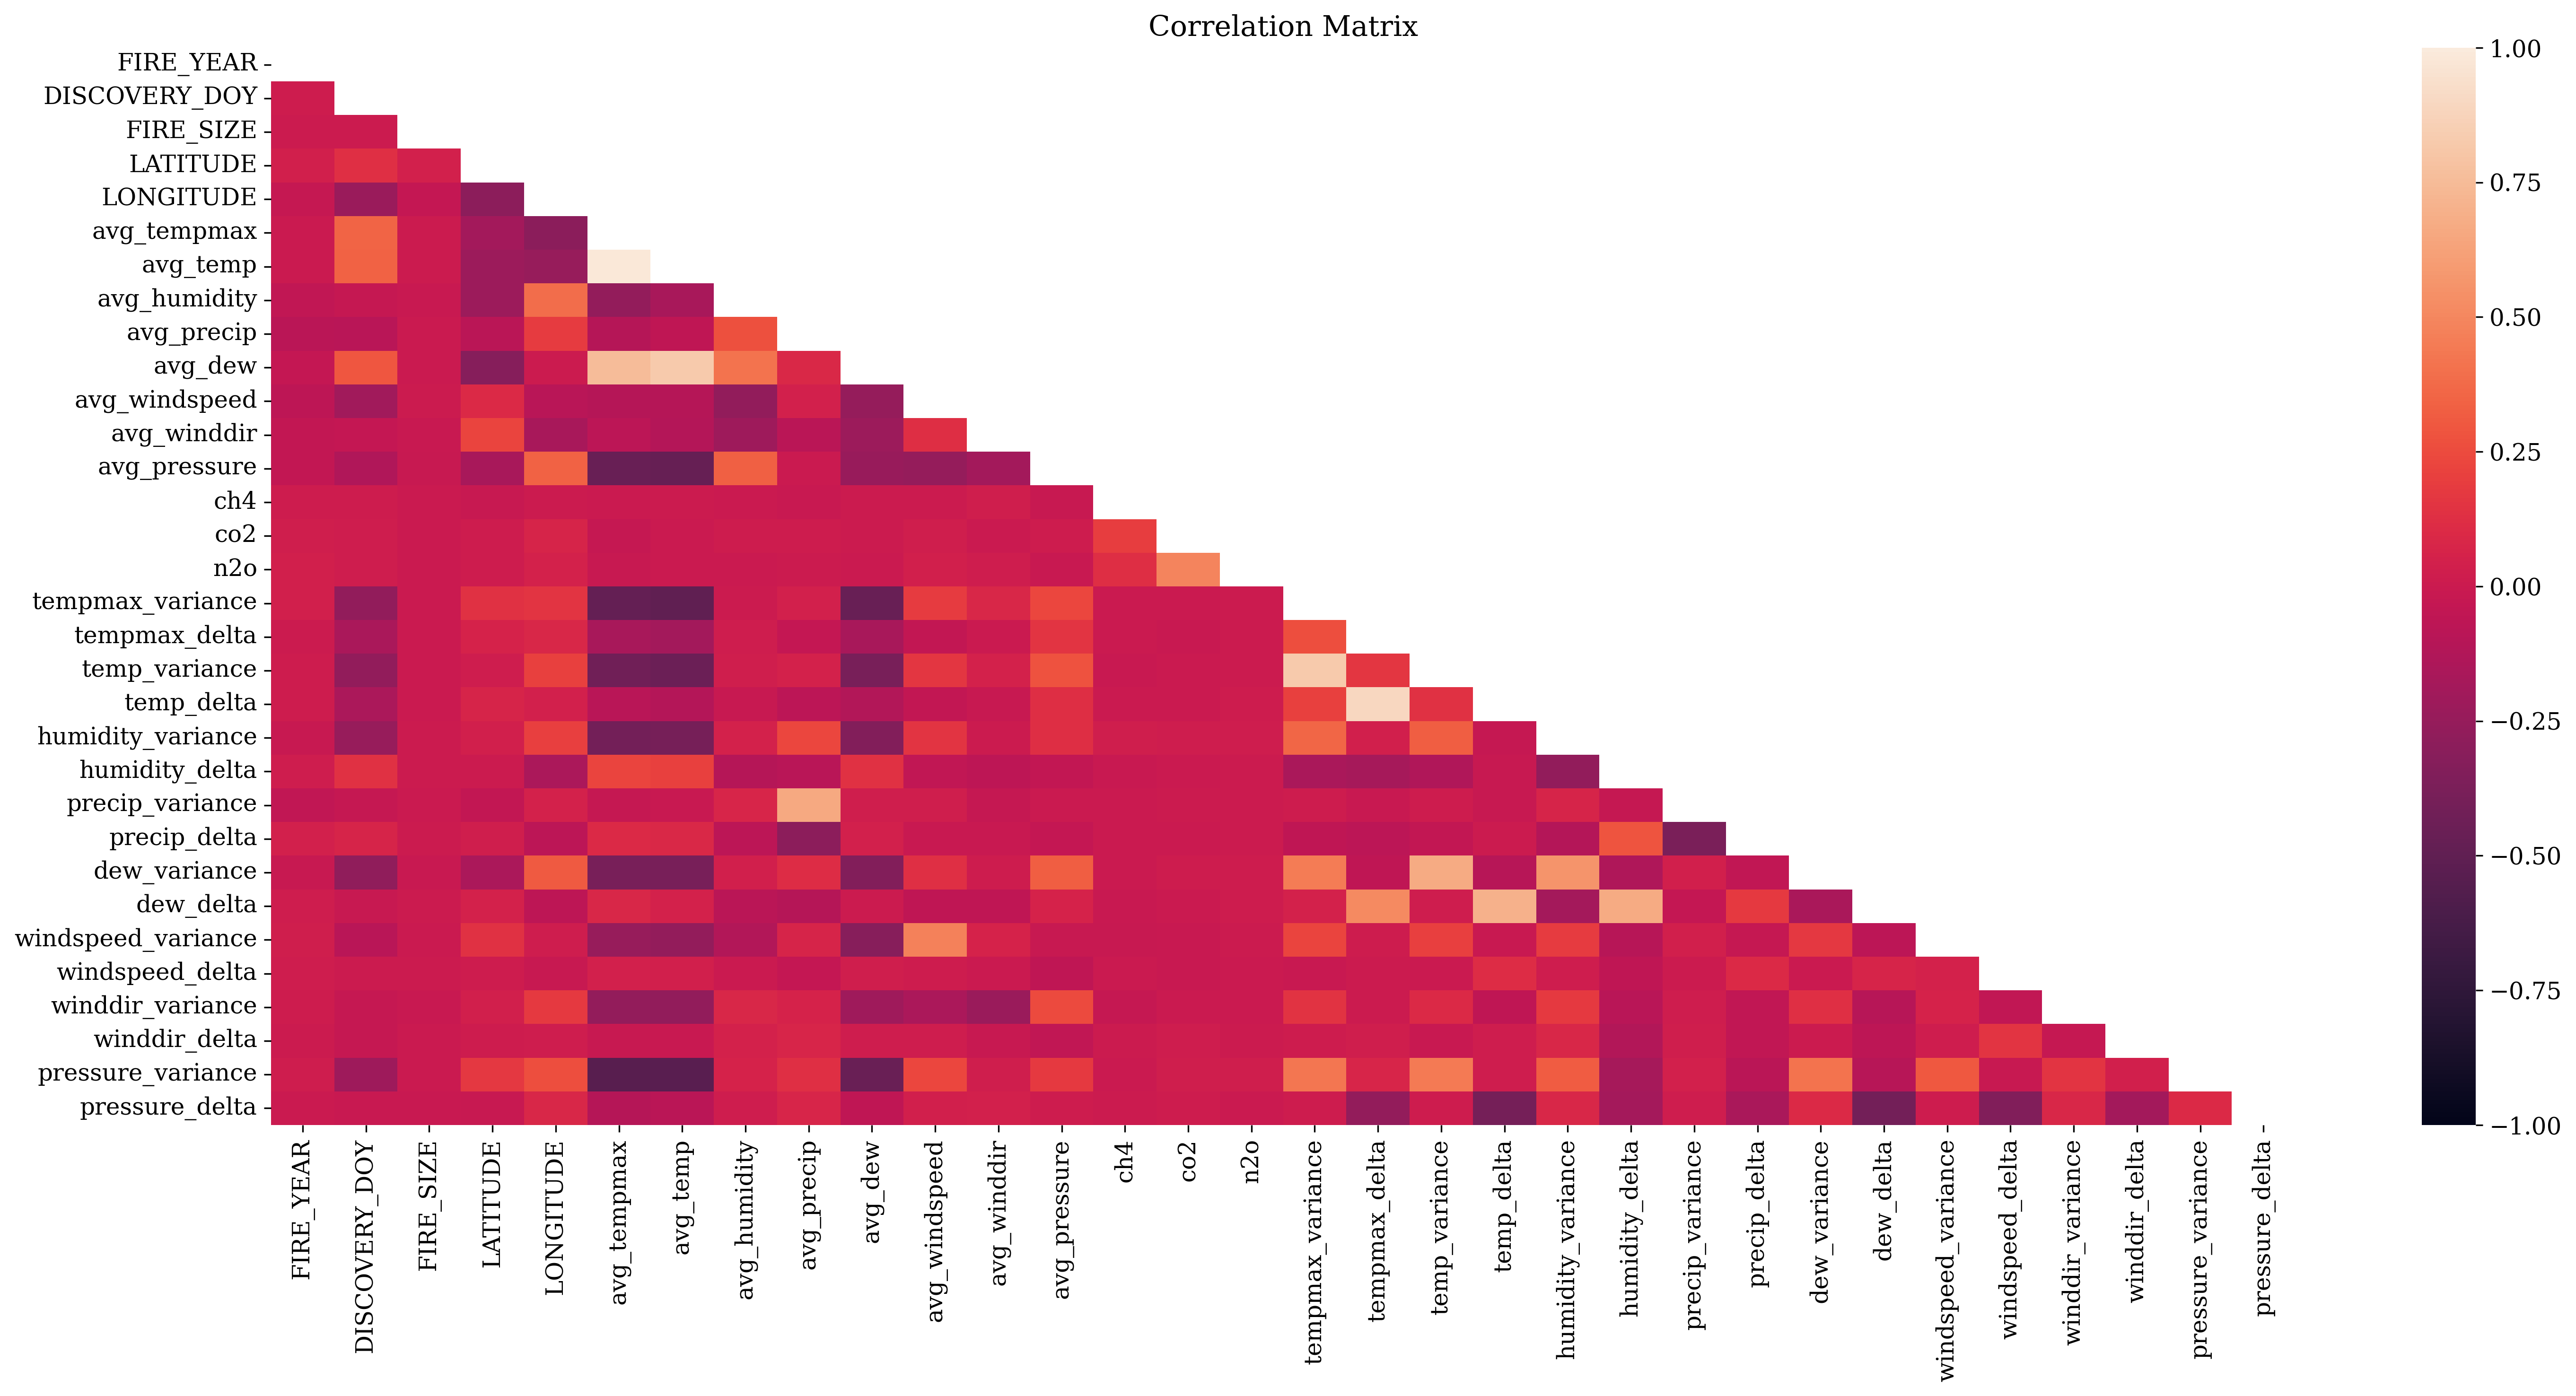

In [43]:
# Plot the correlation using a heatmap
corr = numeric_df.corr()

plt.figure(figsize=(20,10), dpi=300)
plt.title('Correlation Matrix')
matrix = np.triu(corr)
sns.heatmap(corr, mask=matrix, vmin=-1, vmax=1)
plt.show()

Our model hopes to predict the size of a fire - looking at the column for `FIRE_SIZE` we see that there is very little - in fact, almost no - correlation with other features. We see this better in the correlation martix below.

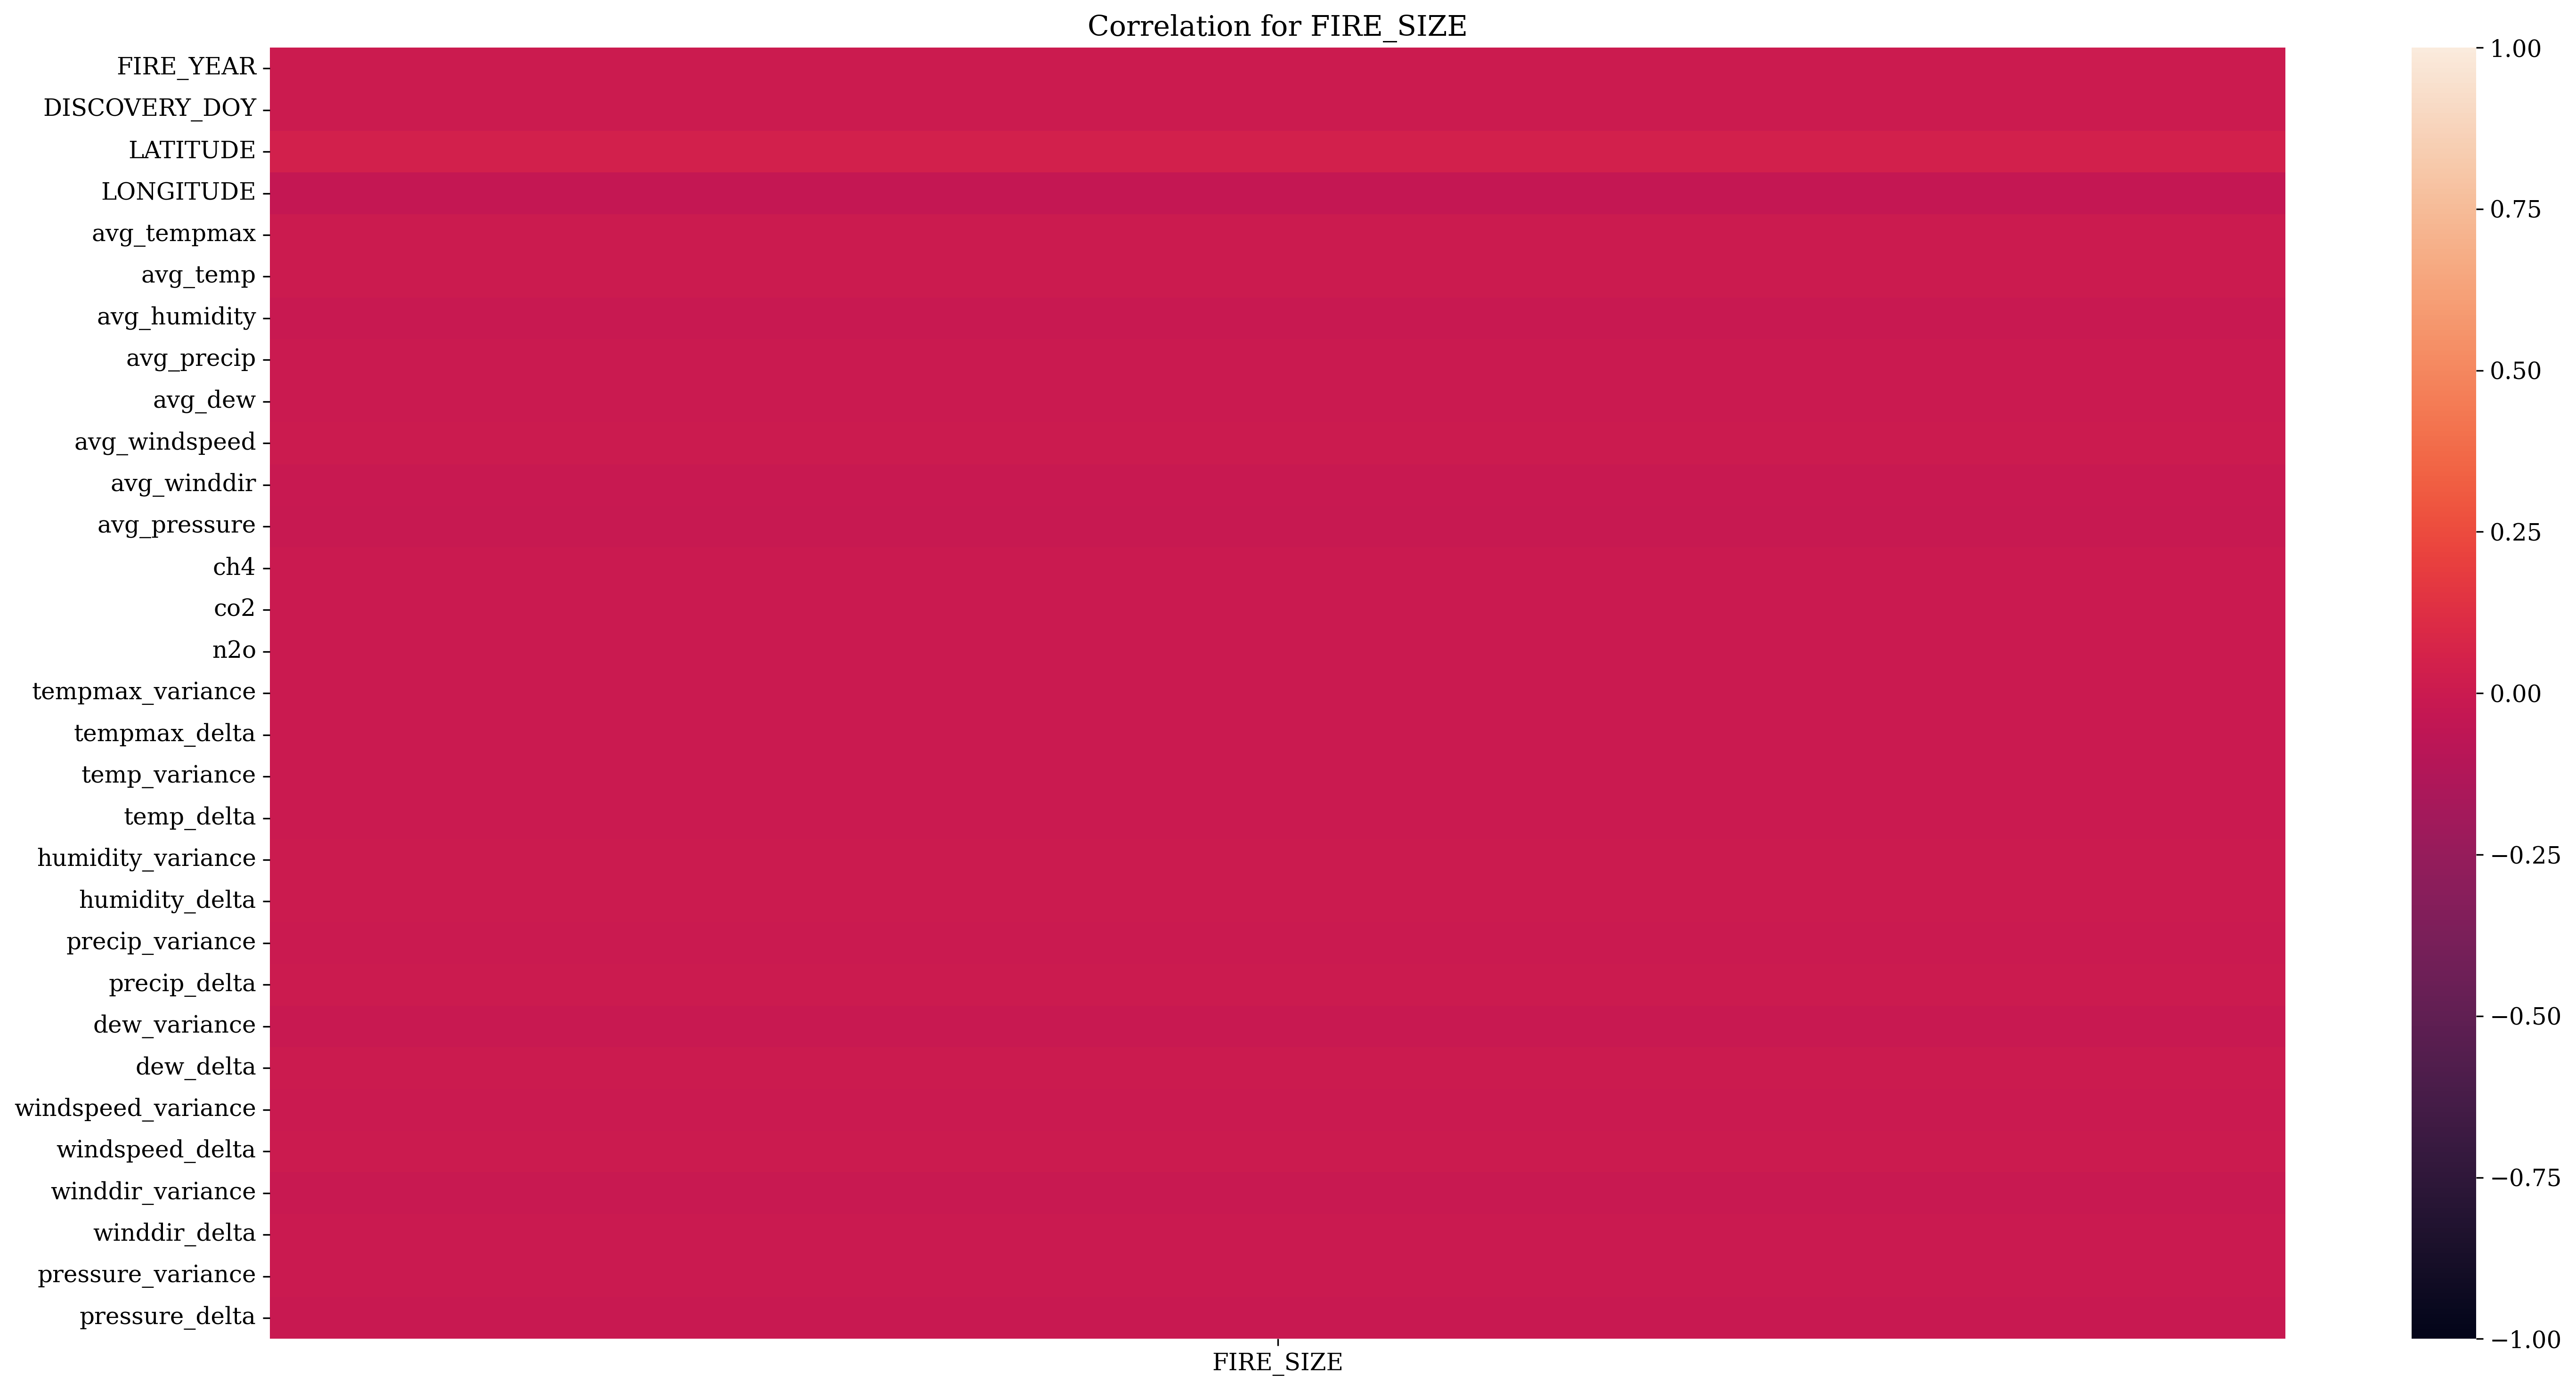

In [48]:
fire_size_corr = corr[['FIRE_SIZE']].drop('FIRE_SIZE', axis=0)

plt.figure(figsize=(20,10), dpi=300)
plt.title('Correlation for FIRE_SIZE')
sns.heatmap(fire_size_corr, vmin=-1, vmax=1)
plt.show()

---
<a id='relationships'></a>
## Exploring the Relationships Between Variables

On the basis of the previous exploration, can any be used to predict the others? To figure this out, it helps to begin by plotting variables against each other, to visualize the relationship between them.

In [49]:
X_input = numeric_df.drop('FIRE_SIZE', axis=1)
X_input.head()

FIRE_YEAR  DISCOVERY_DOY   LATITUDE   LONGITUDE  avg_tempmax   avg_temp  \
0       1992              1  43.325000 -101.018500     5.257143  -2.928571   
1       1992              1  33.058333  -79.979167    13.700000   9.885714   
2       1992              2  40.775000  -74.854160     6.385714   1.585714   
3       1992              3  31.018500  -83.297300    14.457143  11.828571   
4       1992              3  30.728900  -87.238100    14.428571  10.985714   

   avg_humidity  avg_precip   avg_dew  avg_windspeed  ...  precip_variance  \
0     81.142857    0.000000 -6.071429      18.371429  ...         0.000000   
1     81.428571    4.185714  6.671429      23.514286  ...        55.589796   
2     67.185714    1.394286 -4.242857      18.157143  ...         9.546510   
3     78.957143    4.685714  8.128571      19.200000  ...        59.321224   
4     79.971429    0.188571  7.500000      17.000000  ...         0.213355   

   precip_delta  dew_variance  dew_delta  windspeed_variance  windspeed_delta  \
0          0.00      5.399184        3.5           47.062041             -1.8   
1         -4.40      7.196327        0.1            5.575510              2.0   
2          0.00     19.731020        4.0           34.516735            -10.6   
3         -9.70      9.142041       -4.1           11.228571              0.2   
4         -1.32     10.262857       -7.9           27.382857              6.7   

   winddir_variance  winddir_delta  pressure_variance  pressure_delta  
0       1889.074286          -48.6          28.913469            -4.3  
1      15648.559592          -14.9          19.071020             2.4  
2      16492.948163         -254.6          75.711429            -0.9  
3      16679.204898          223.6          21.585306            -8.4  
4      19587.093469          -24.8          13.107755            -2.7  

[5 rows x 31 columns]

In [50]:
from math import ceil

columns = 4
rows = ceil(len(X_input.columns) / columns)

plt.subplots(rows, columns, figsize=(30,30), dpi=300)

for index, col in enumerate(X_input):
    position = index + 1
    plt.subplot(rows, columns, position)
    sns.histplot(x=X_input[col], 
                 y=df_cleaned['FIRE_SIZE_CLASS'],
                 kde=True)

plt.tight_layout()
plt.show()

---
<a id='base_linreg'></a>
## Baseline Linear Regression

<a id='prep'></a>
### Preparation

In order to build this model there are a few things that we have to do before hand. First, we need to format the data - this includes transformations on skewed data using Boxcox.

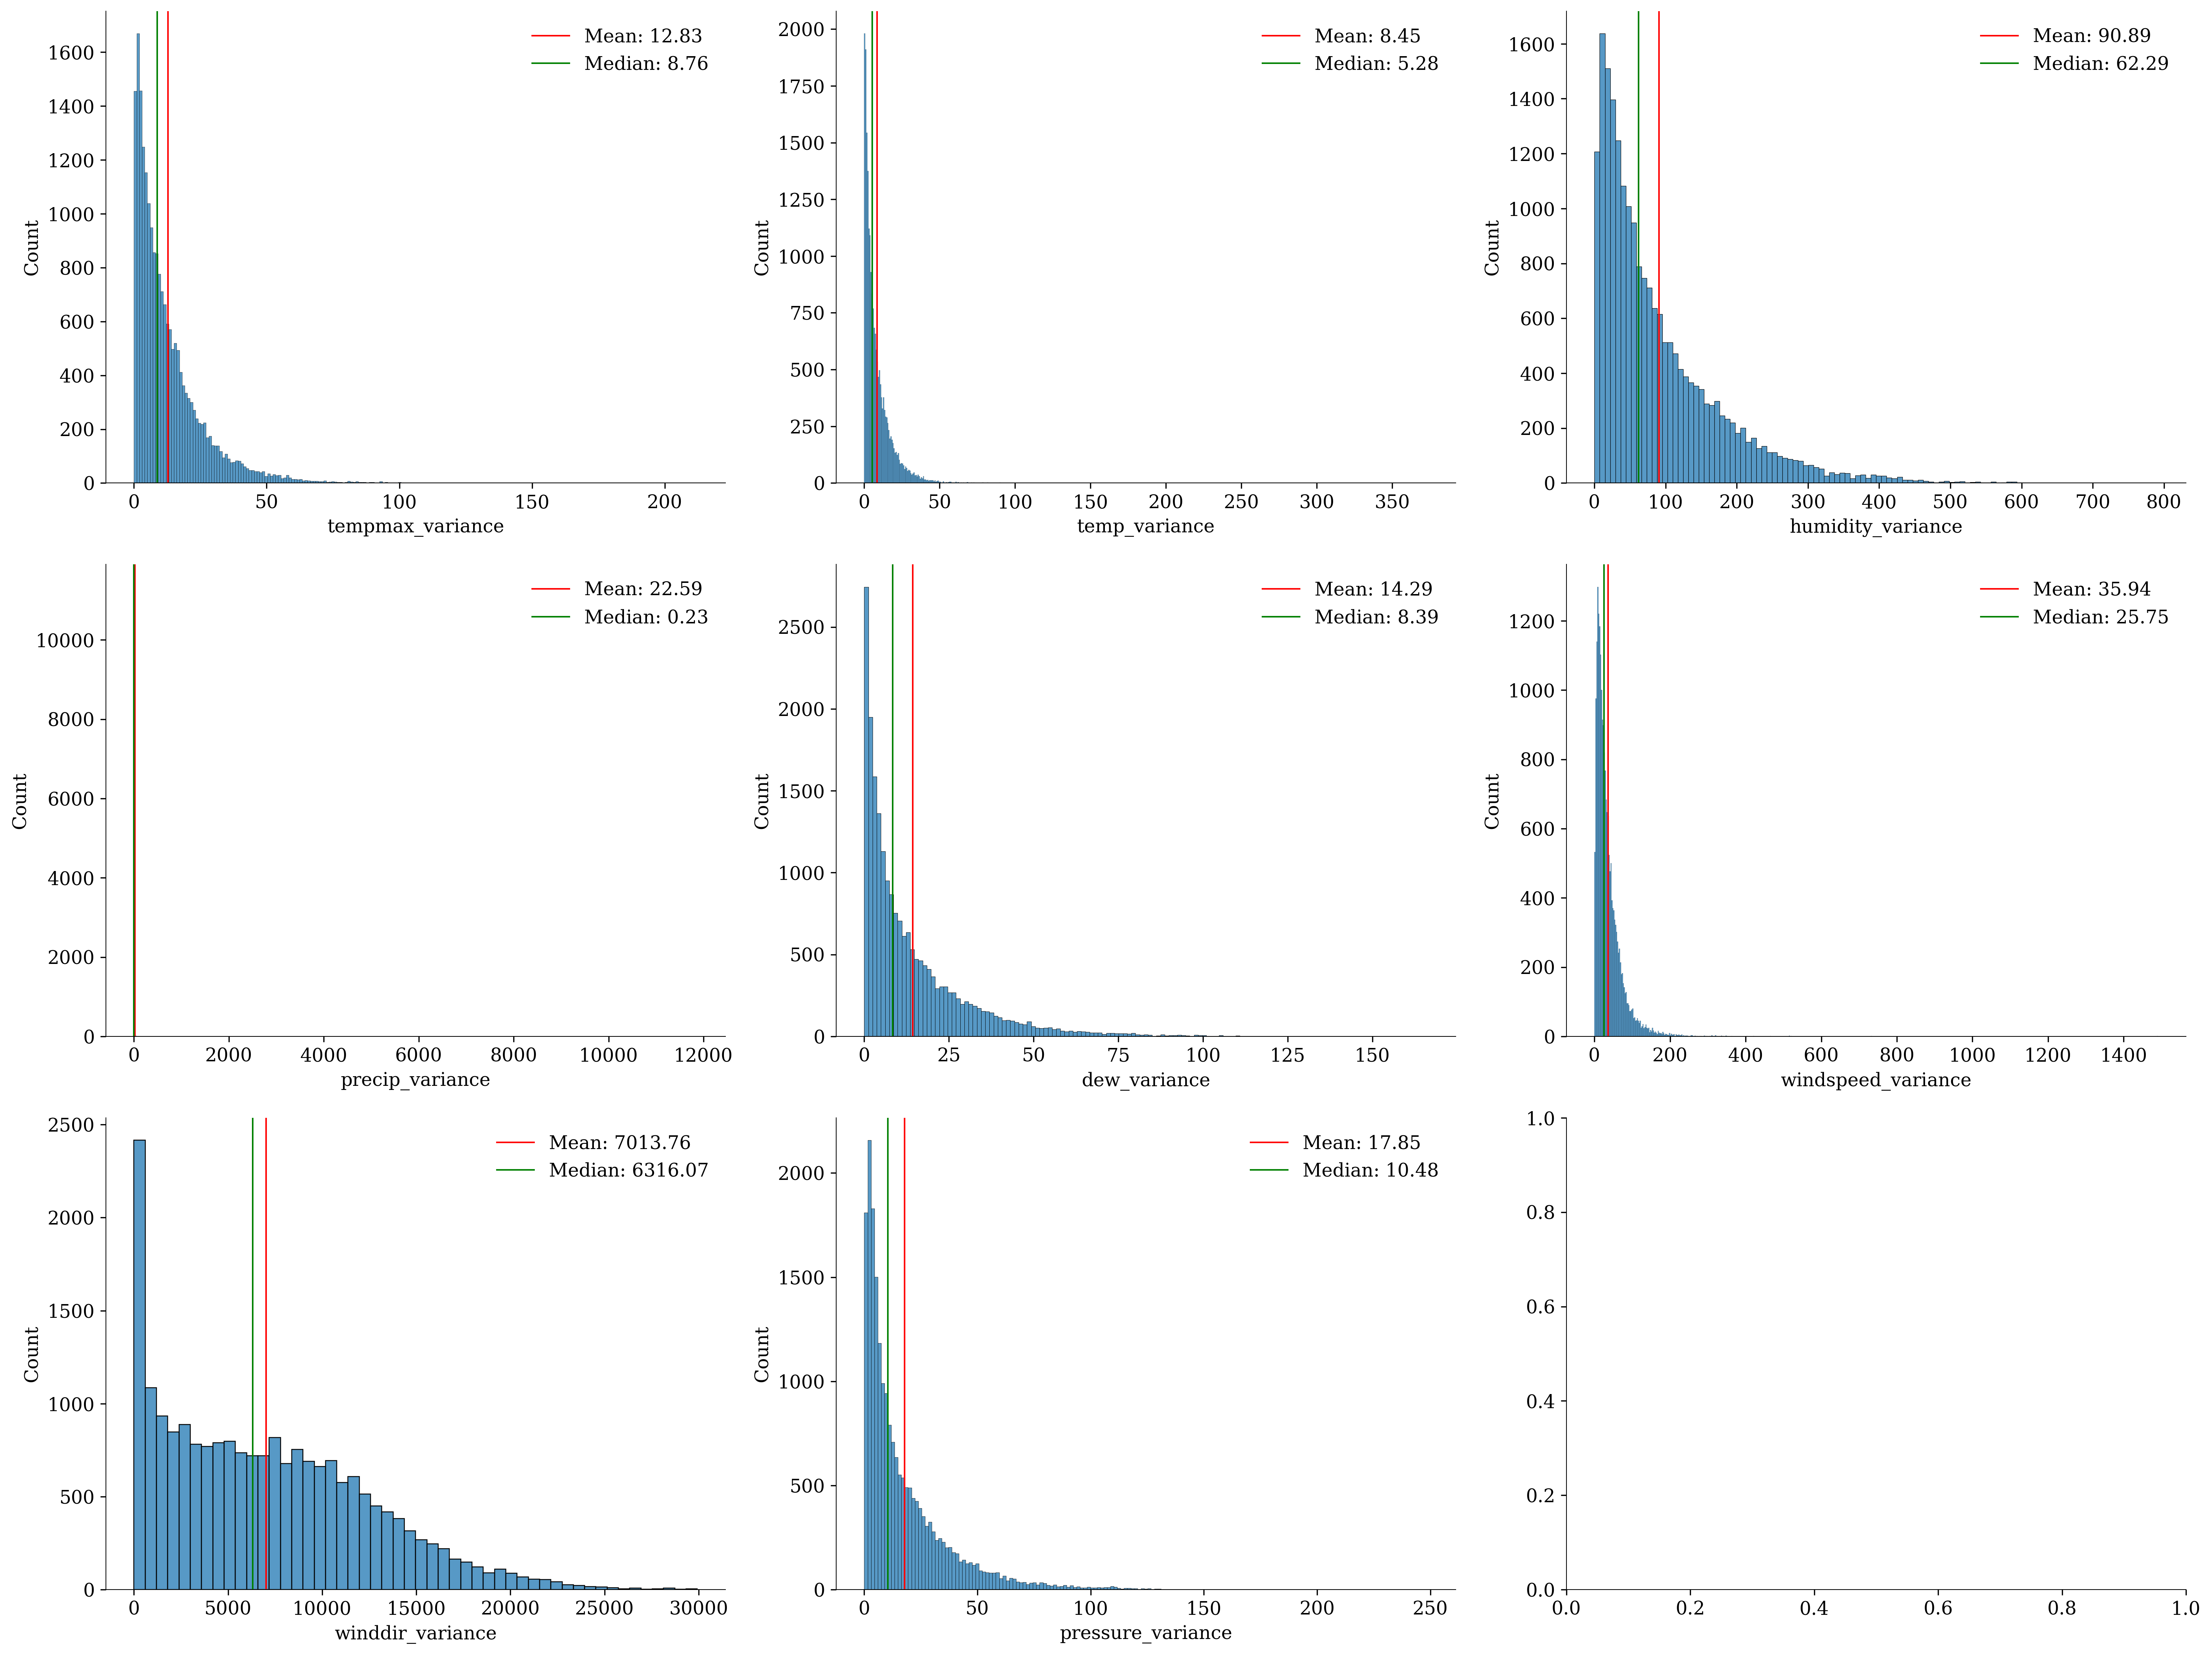

In [51]:
boxcox_cols = [col for col in numeric_df.columns
               if 'variance' in col]

utils.HistogramSubplots(numeric_df[boxcox_cols], figsize=(20, 15))

For our linear regression model we require the columns to be normal - these are heavily right skewed, meaning they do not conform to our assumptions of a linear regression. We can transform these columns using a Box-cox transformation to see whether we are able to normalise their distribution. To do Box-Cox, the variables need to be greater than 0. Let us look at the variables and see whether they fall within the range:

In [52]:
numeric_df[boxcox_cols].describe().T

count         mean          std       min          25%  \
tempmax_variance    20851.0    12.828399    13.465794  0.001224     3.499184   
temp_variance       20851.0     8.447304     9.943393  0.012653     1.989796   
humidity_variance   20851.0    90.893124    88.044584  0.187755    26.417959   
precip_variance     20851.0    22.594312   176.365582  0.000000     0.000000   
dew_variance        20851.0    14.291504    16.451731  0.016735     2.851429   
windspeed_variance  20851.0    35.944840    37.009957  0.291020    12.849592   
winddir_variance    20851.0  7013.763855  5415.470092  0.757143  2344.036327   
pressure_variance   20851.0    17.848506    20.582998  0.033878     3.977551   

                            50%           75%           max  
tempmax_variance       8.756327     17.403673    212.282449  
temp_variance          5.276327     11.563265    373.487755  
humidity_variance     62.291020    128.072857    791.417143  
precip_variance        0.225441      6.803071  11870.070612  
dew_variance           8.393469     19.834898    166.250612  
windspeed_variance    25.747755     47.240612   1490.442449  
winddir_variance    6316.071020  10643.864694  29931.213469  
pressure_variance     10.481224     24.478776    248.764082

We see that the minimum value for precipitation is 0, meaning that we need to remove this from the transformations. Before we change it in the`processed_df`, we should see how the transformation works out.

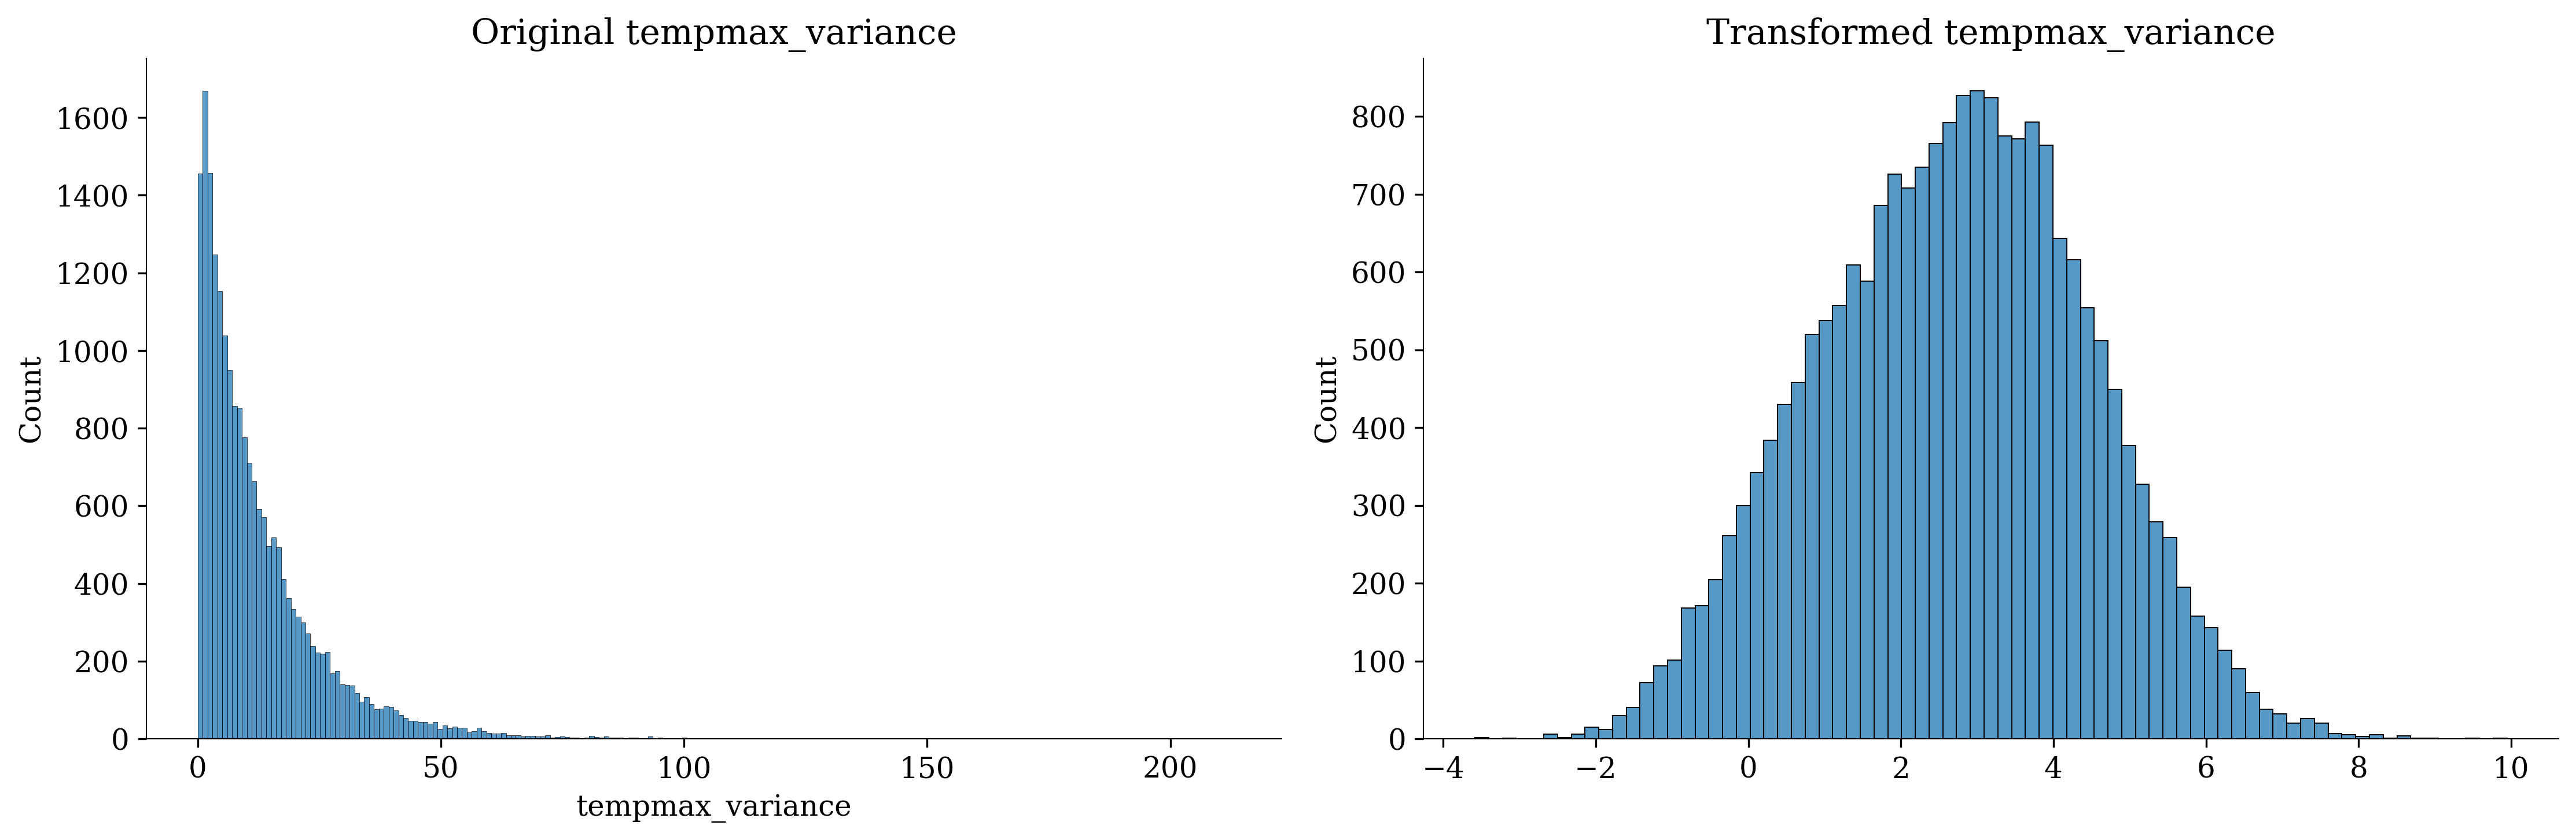

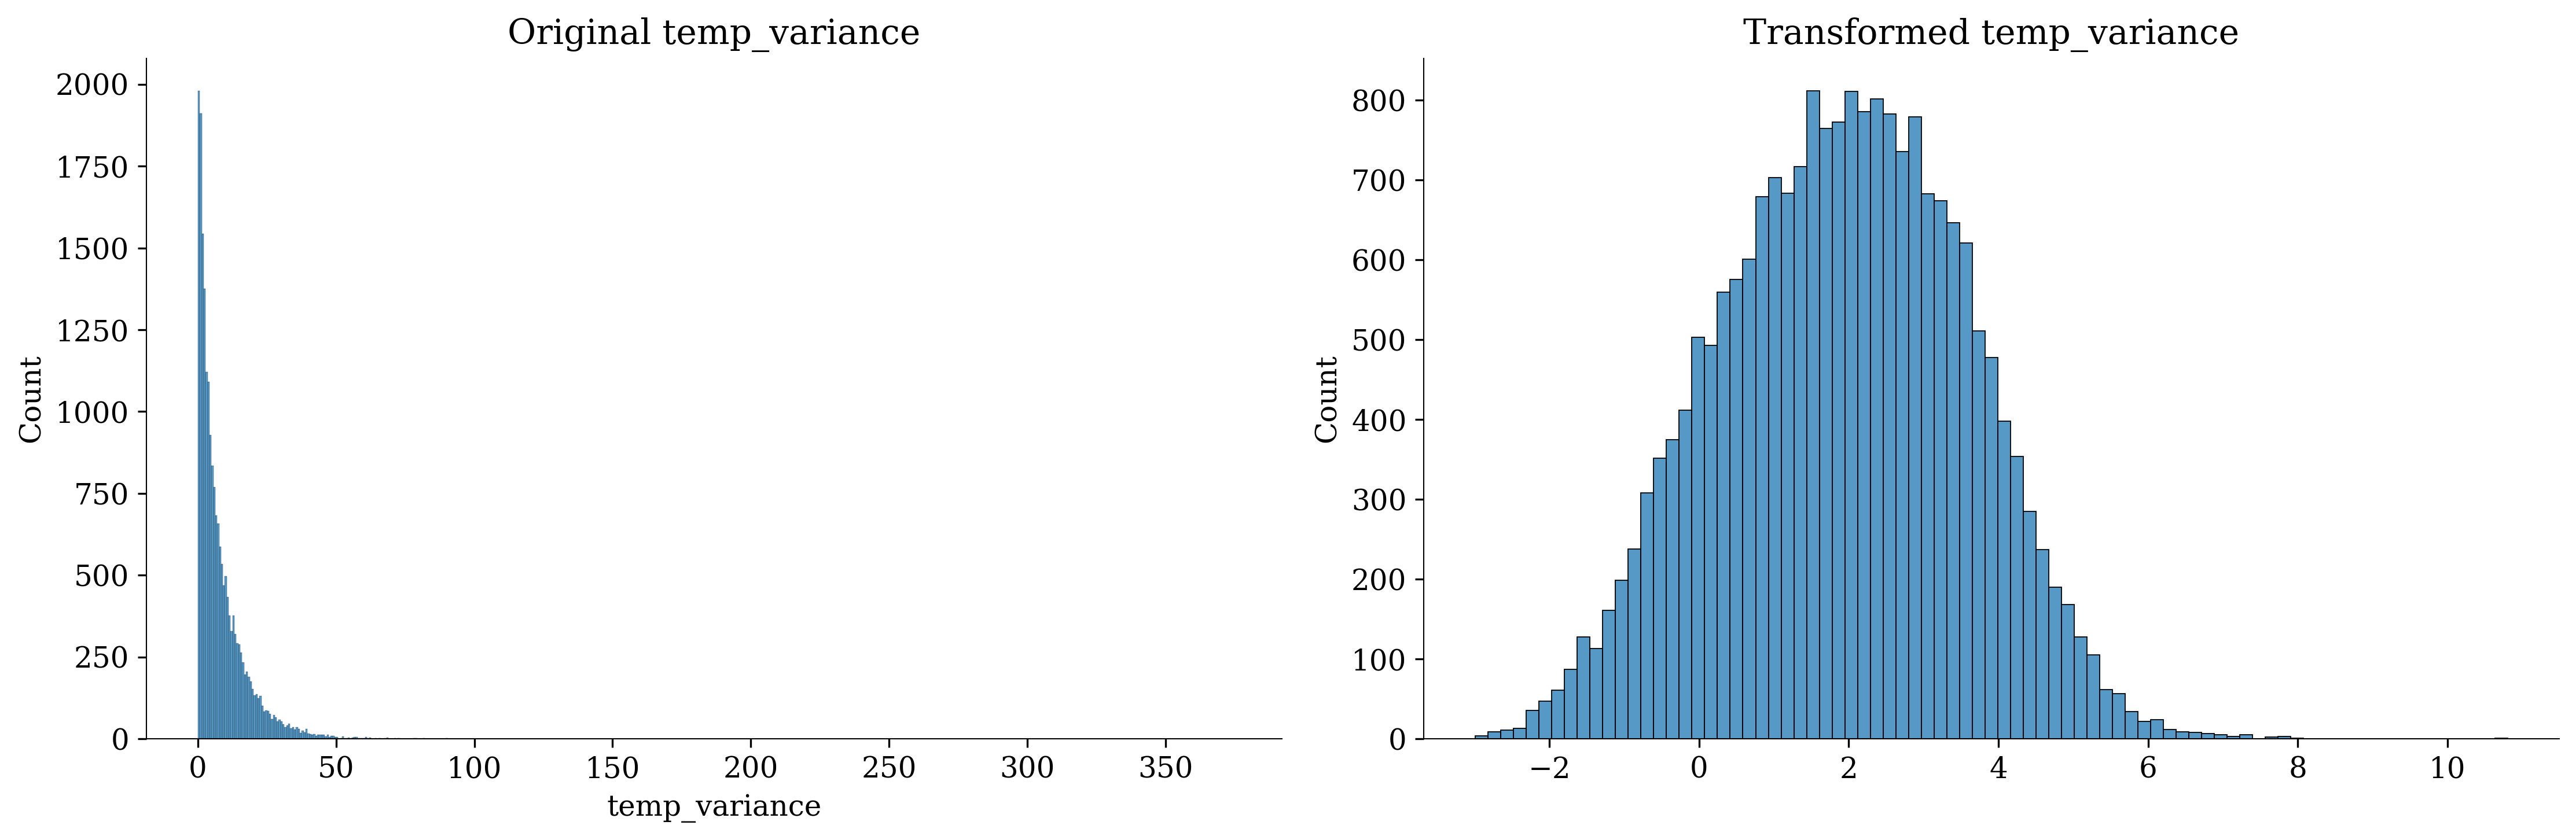

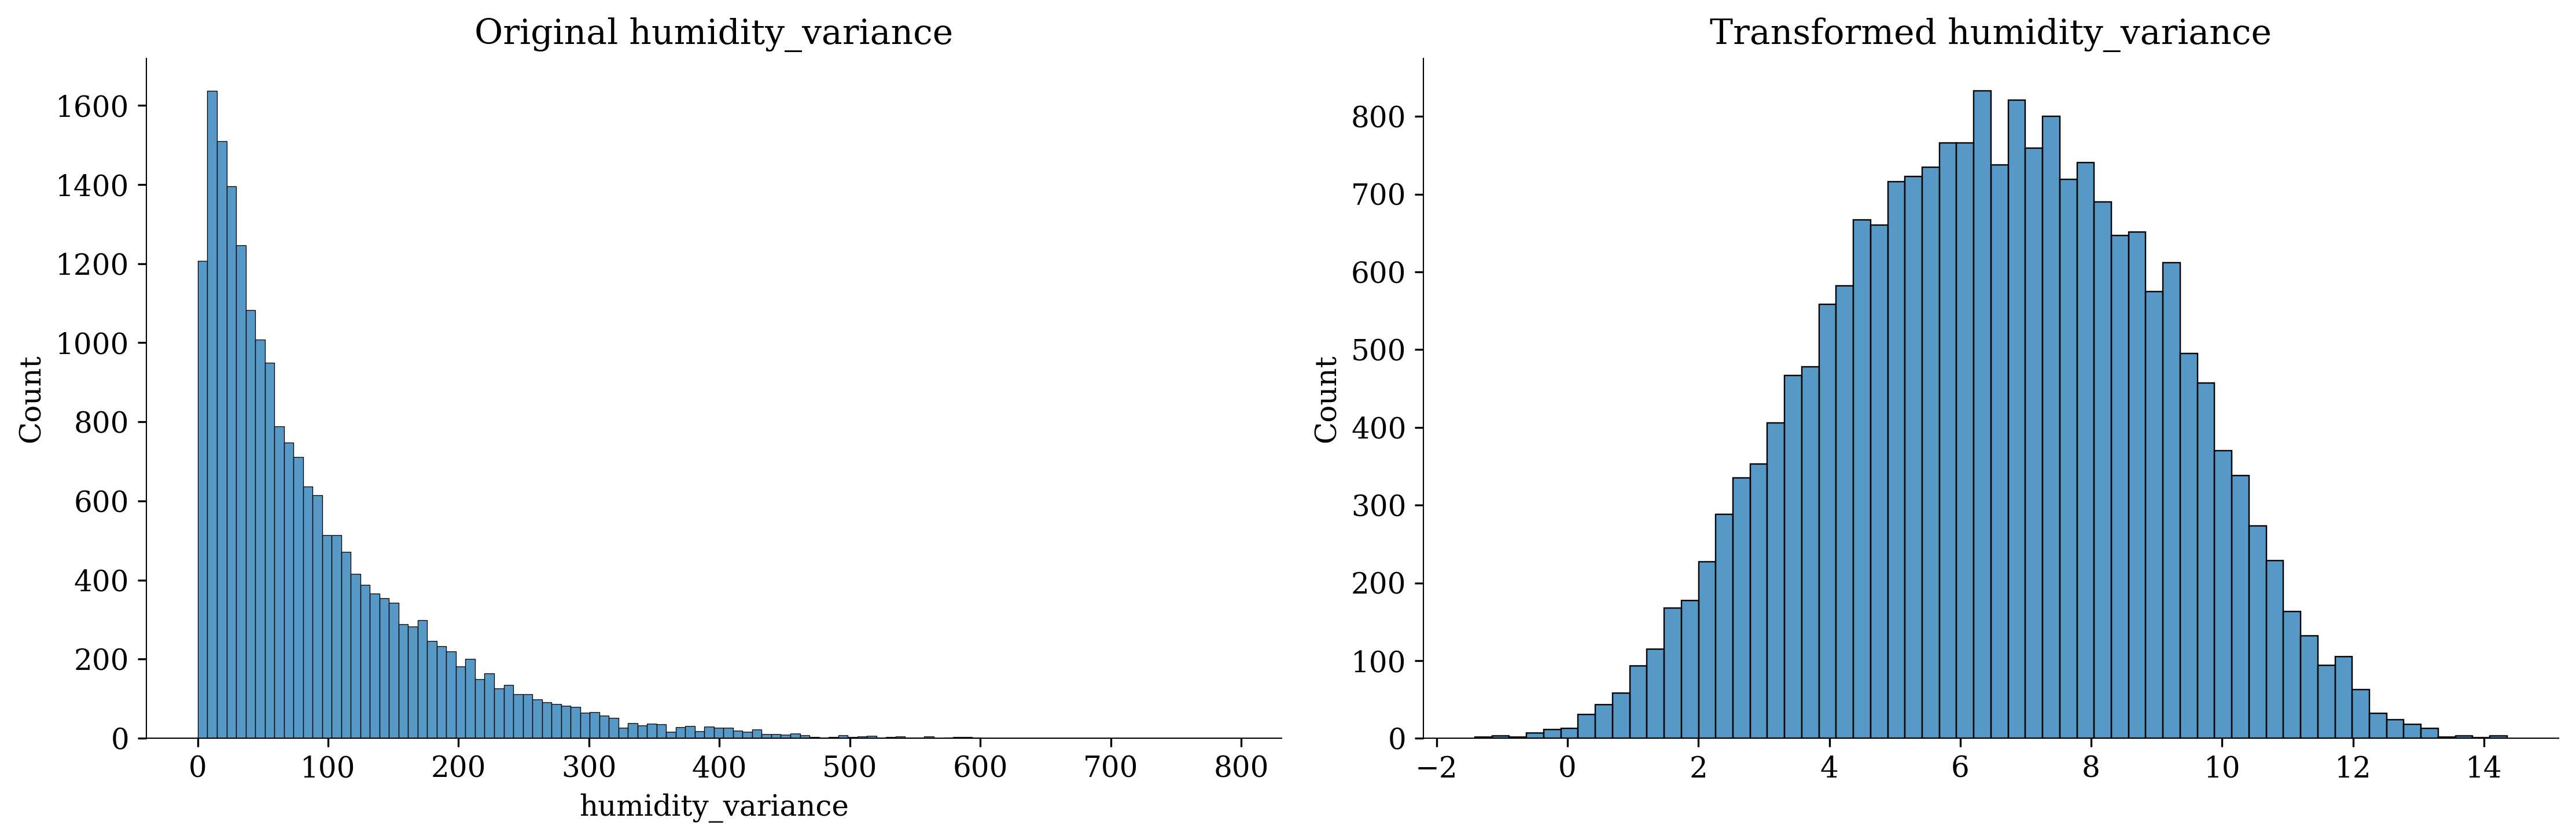

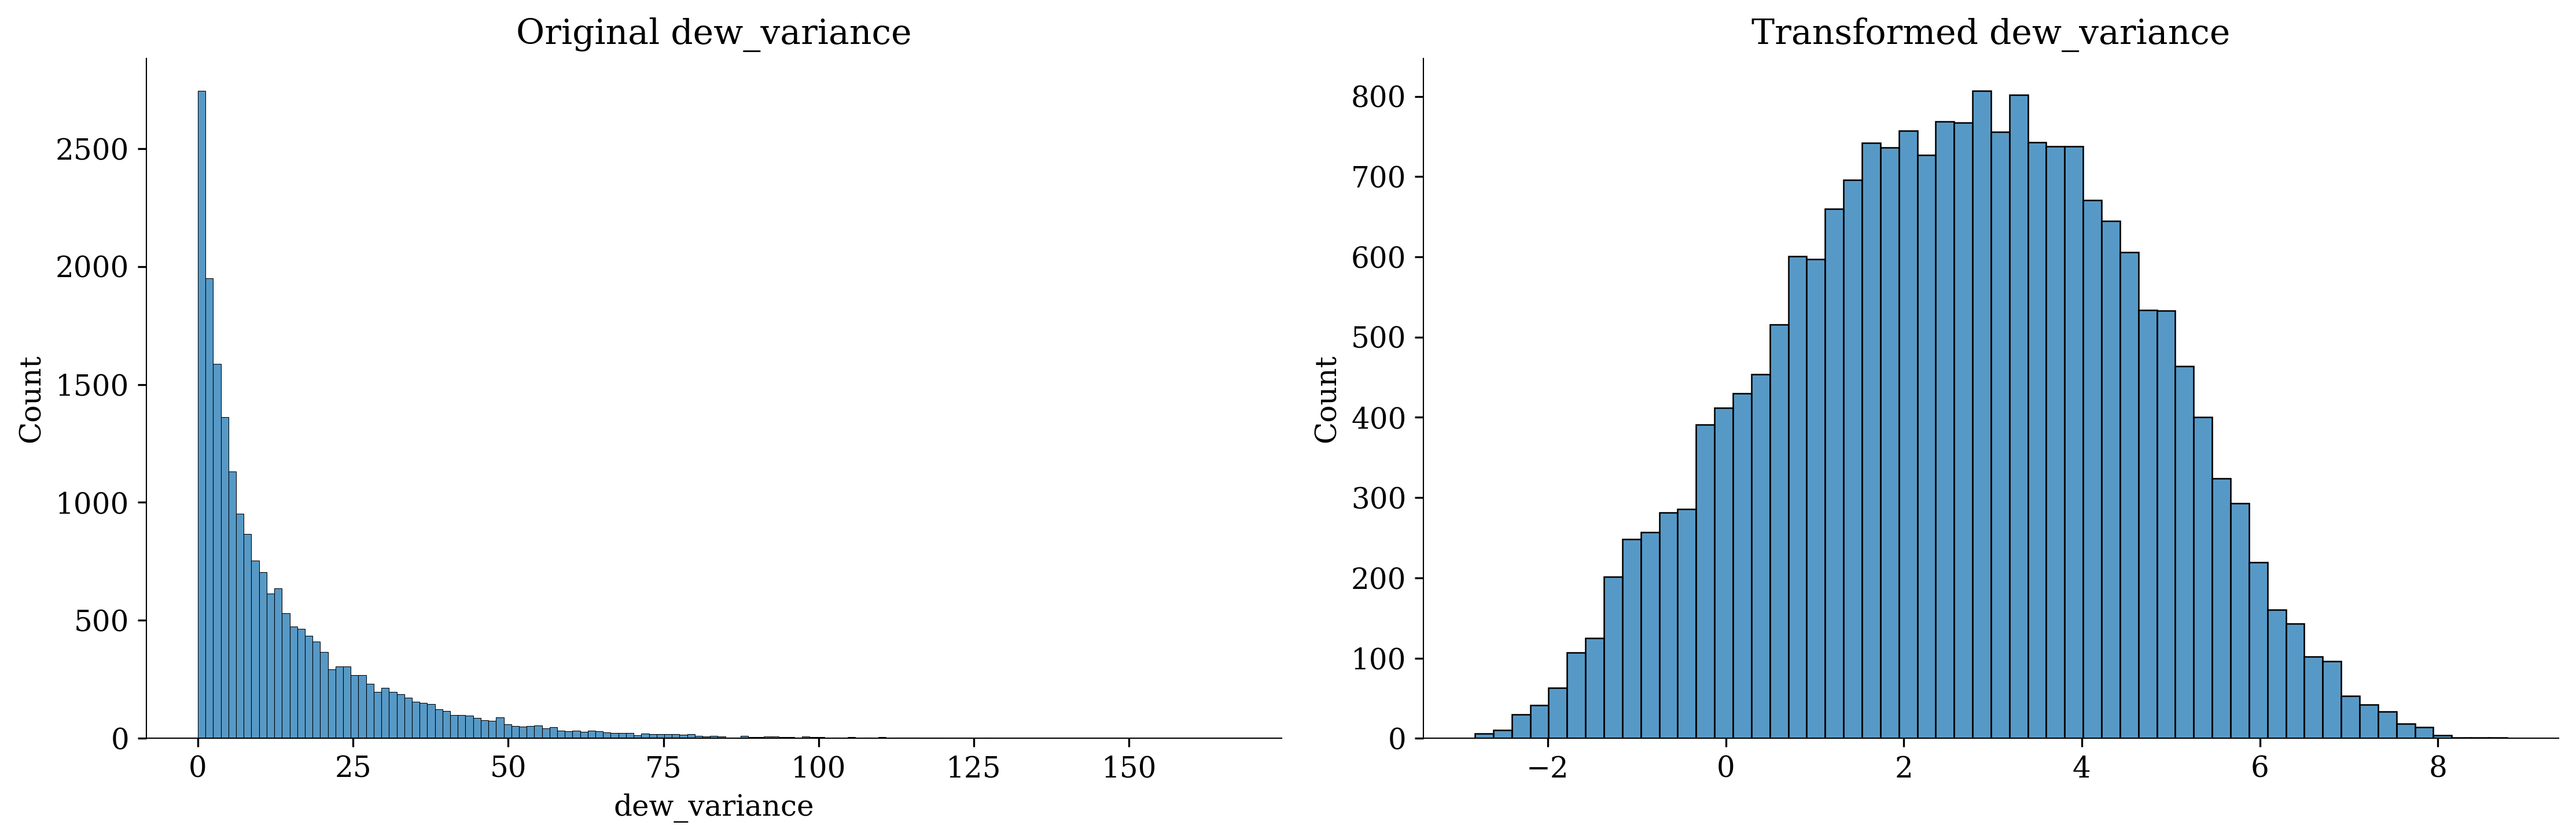

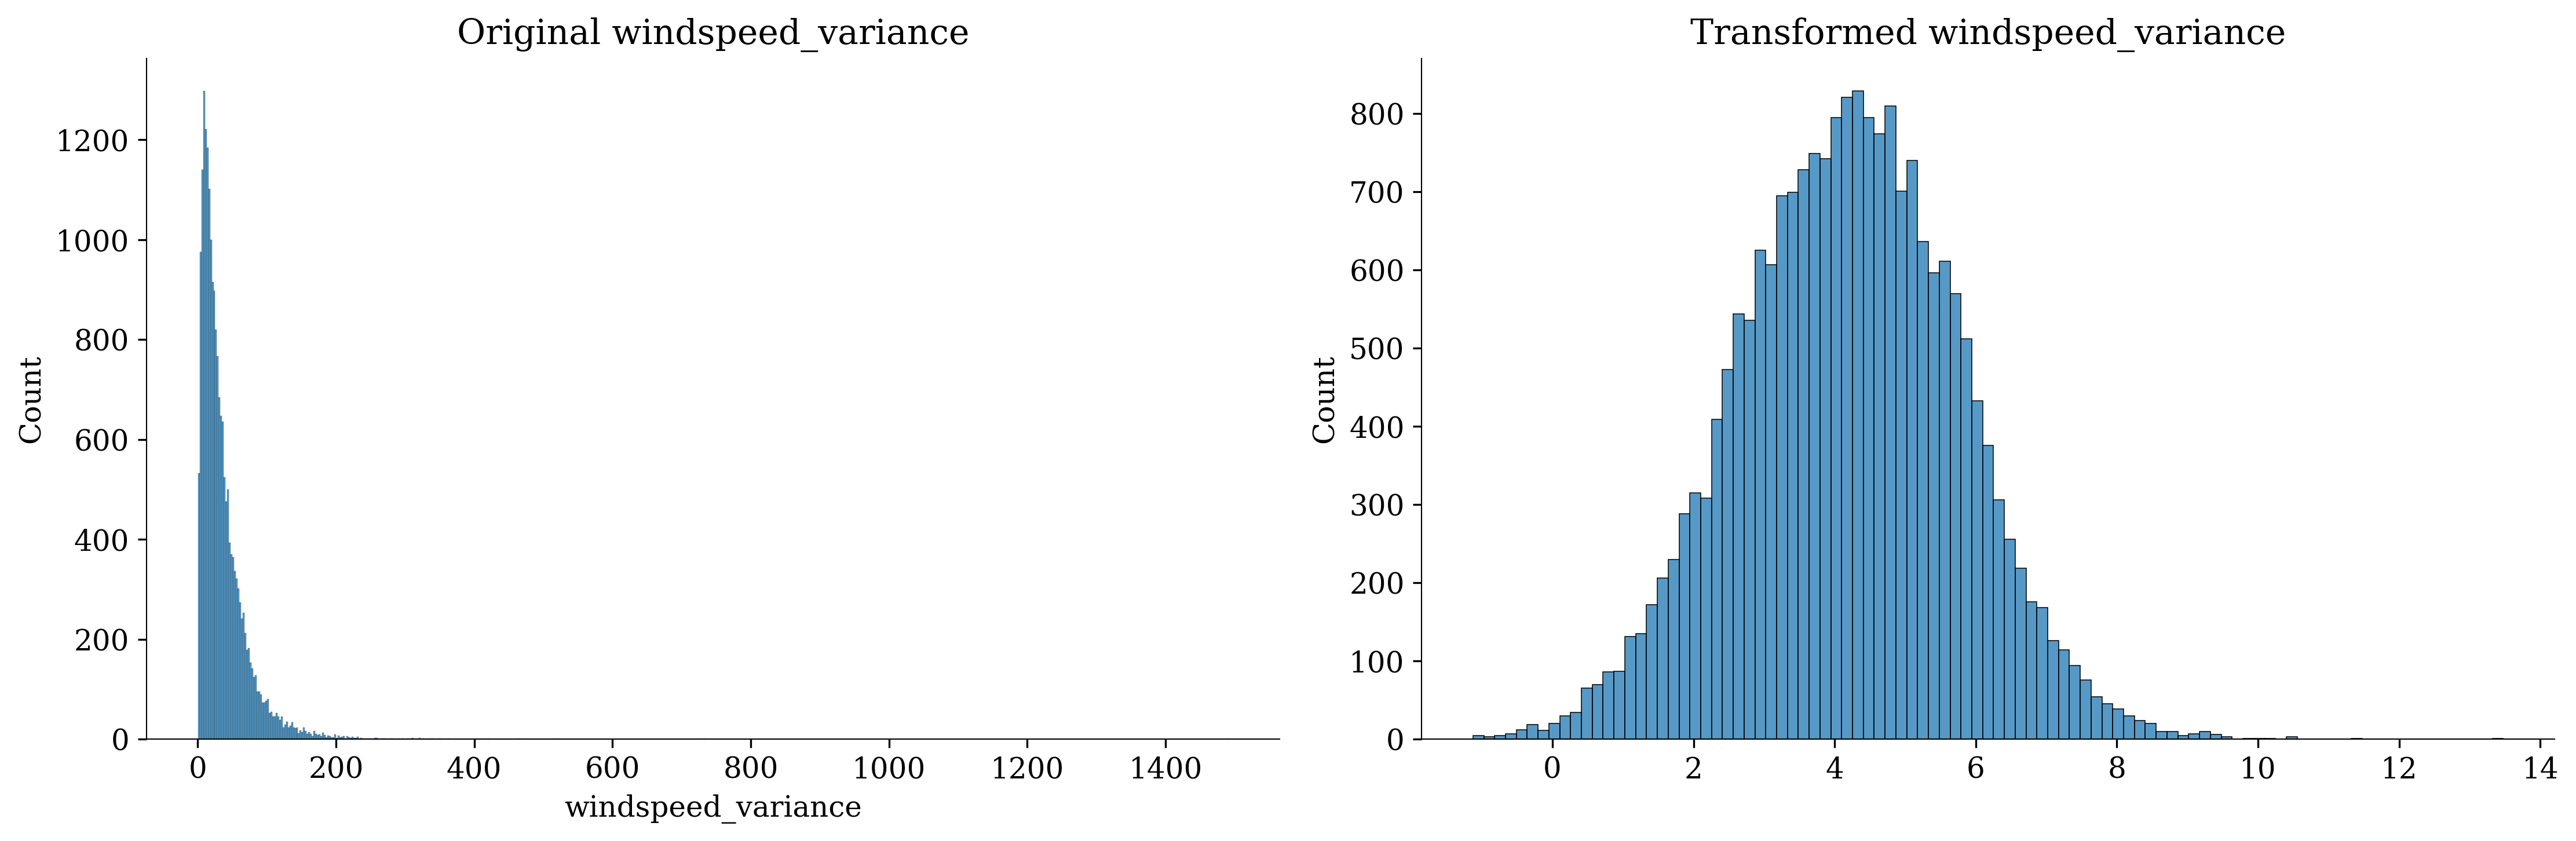

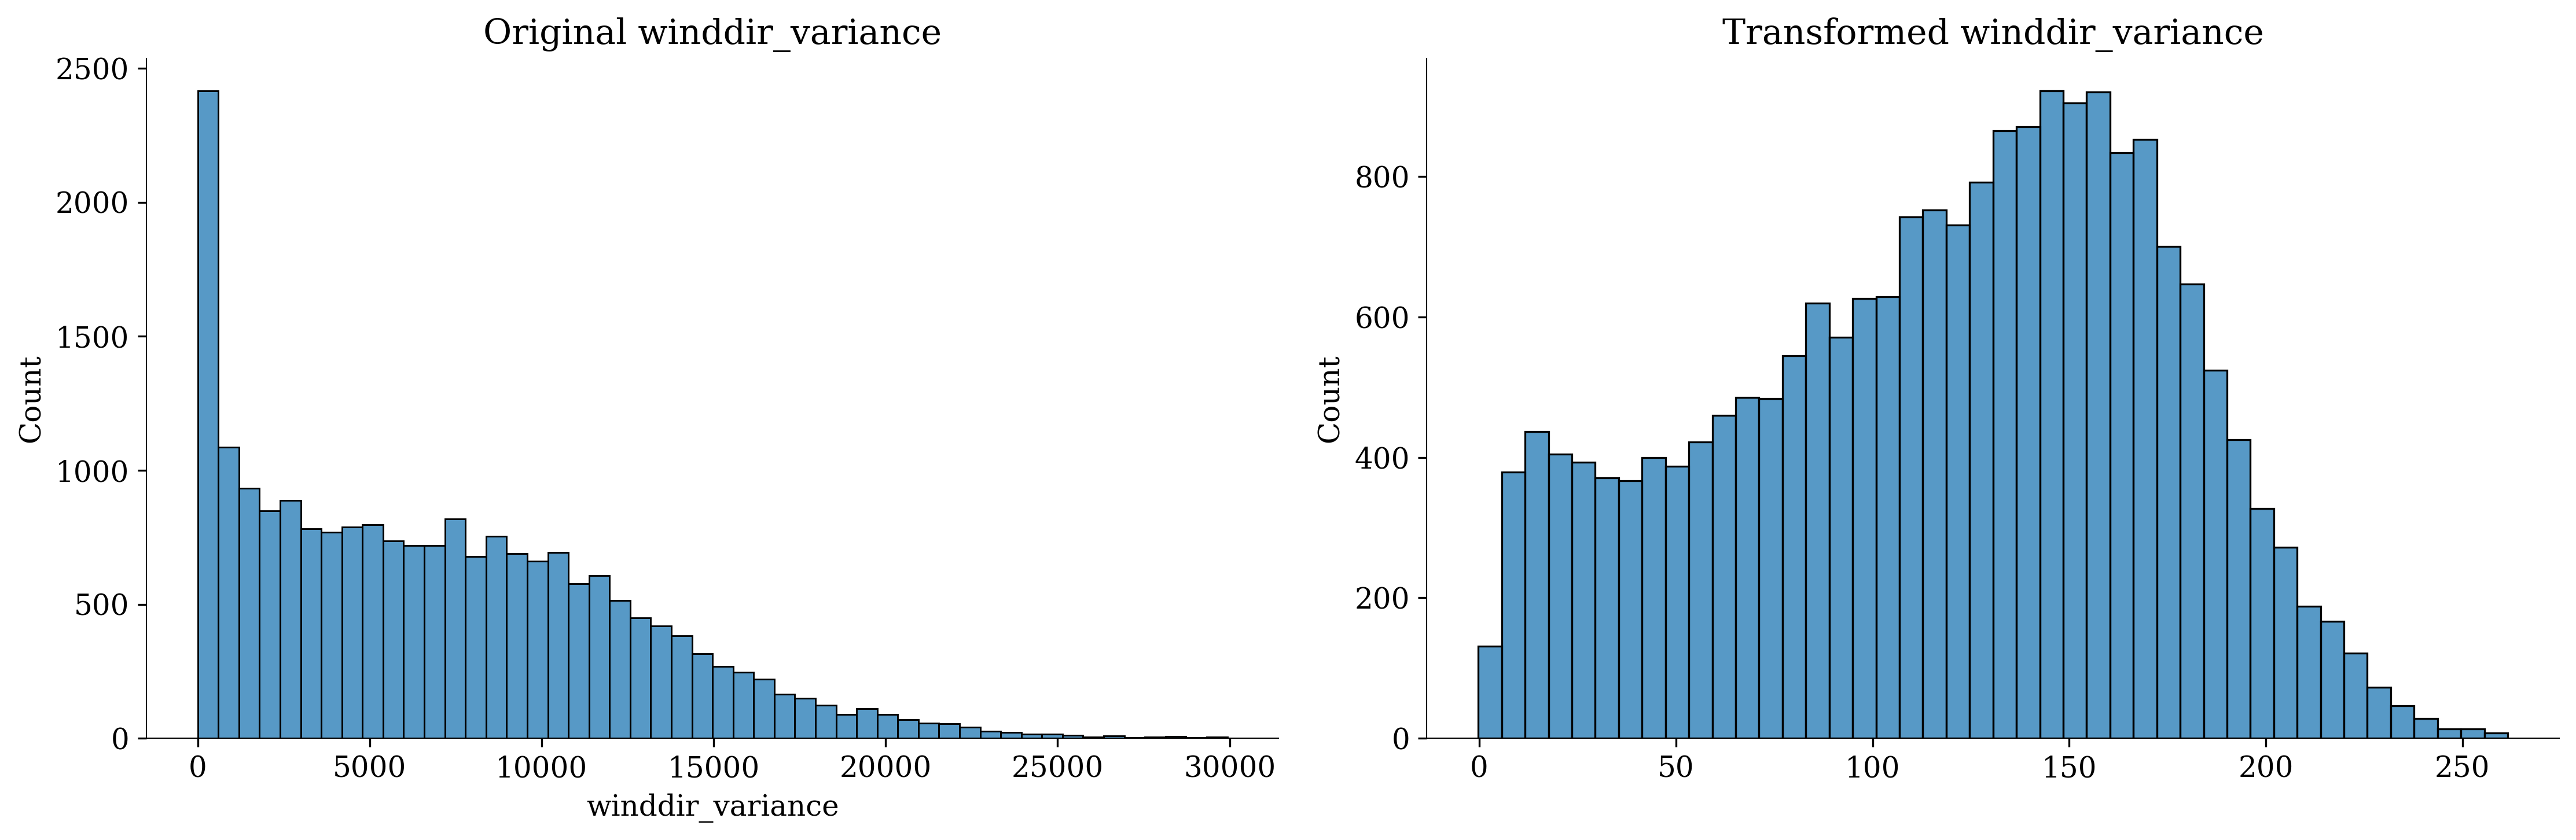

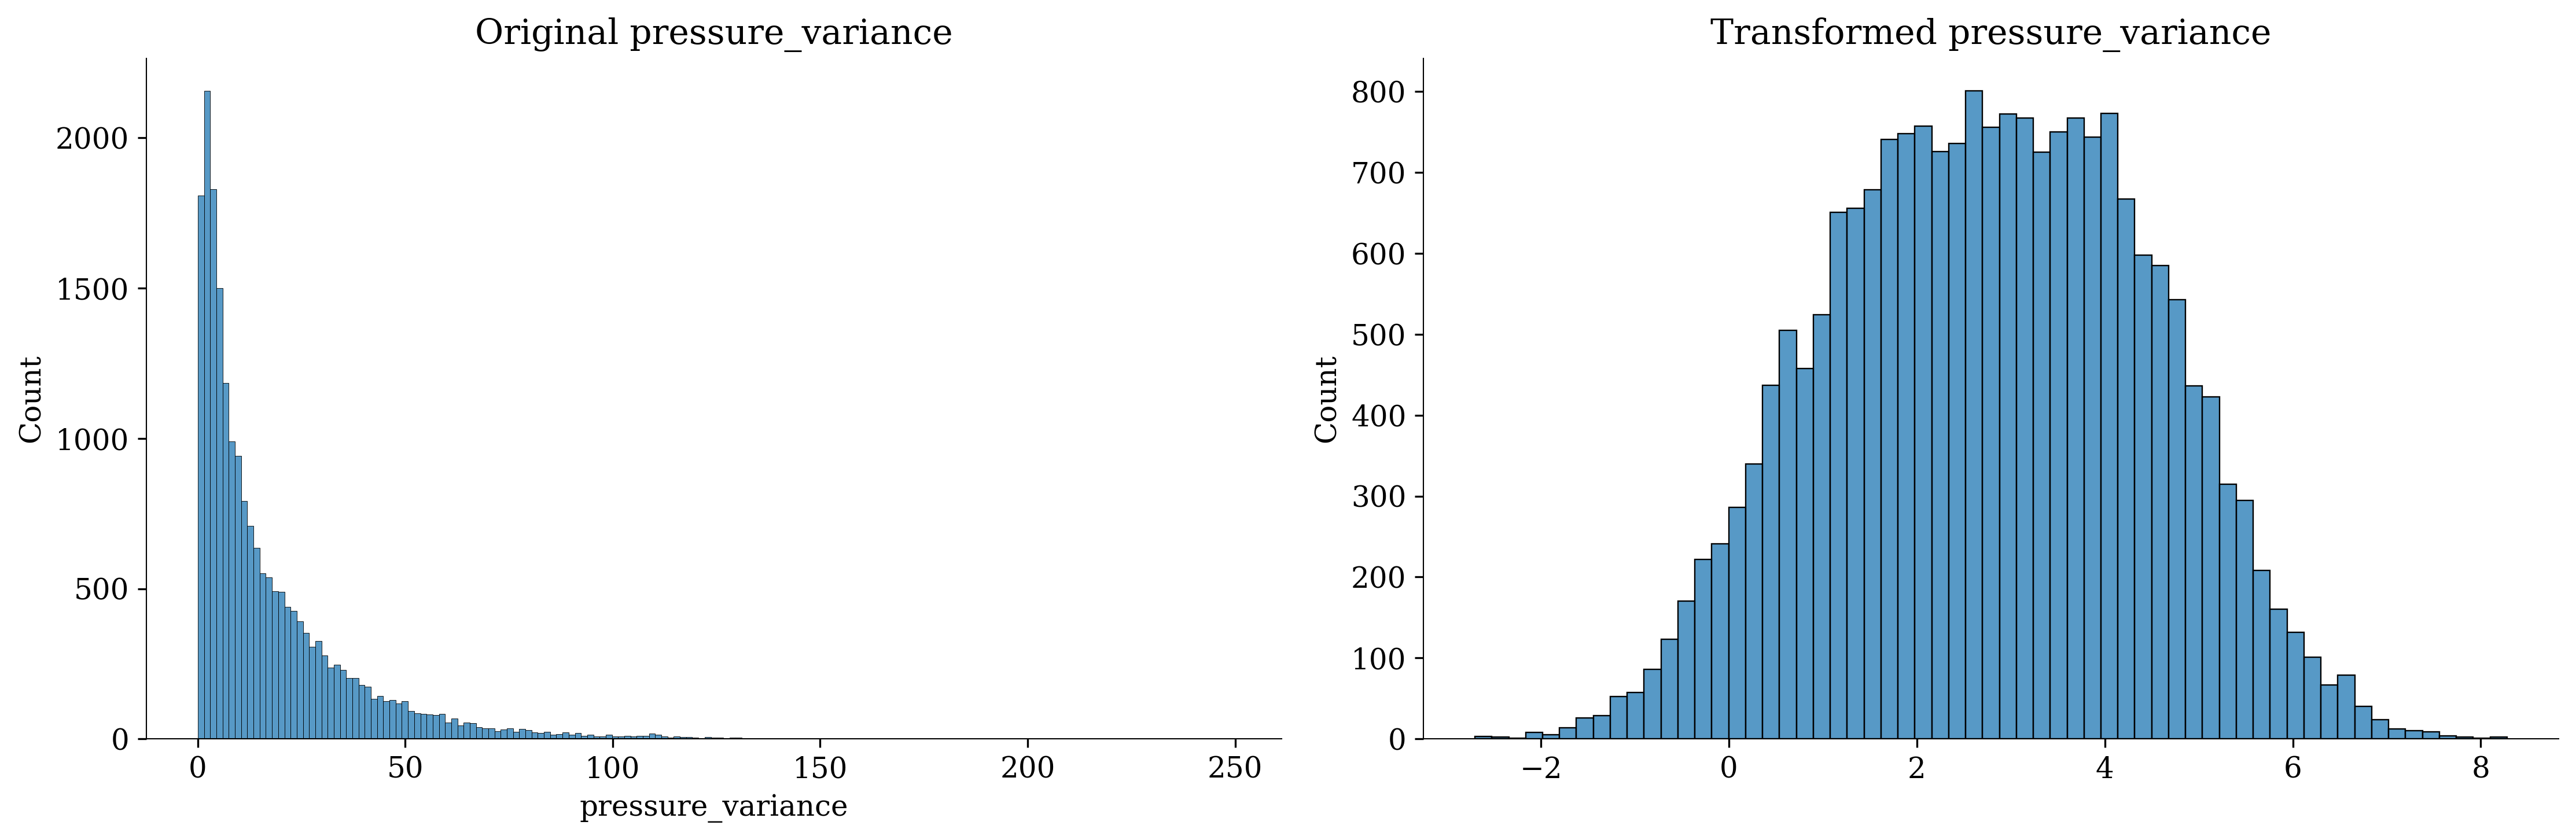

In [53]:
from scipy.stats import boxcox

boxcox_cols.remove('precip_variance')

tmp = numeric_df.copy()

for col in boxcox_cols:
    X = numeric_df[col]
    X = boxcox(X)[0]
    
    # Create subplots
    plt.subplots(1, 2, dpi=300, figsize=(15, 5))
    
    # Plot original
    plt.subplot(1, 2, 1)
    plt.title(f'Original {col}')
    sns.histplot(x=numeric_df[col])
    
    plt.subplot(1, 2, 2)
    plt.title(f'Transformed {col}')
    sns.histplot(x=X)

We see that the transformations has made these columns have a normal distribution which will improve the performance of the model. We can therefore change the values in the DataFrame.

In [54]:
for col in boxcox_cols:
    numeric_df[col] = boxcox(numeric_df[col])[0]

In [55]:
numeric_df.head()

FIRE_YEAR  DISCOVERY_DOY  FIRE_SIZE   LATITUDE   LONGITUDE  avg_tempmax  \
0       1992              1       0.10  43.325000 -101.018500     5.257143   
1       1992              1       1.00  33.058333  -79.979167    13.700000   
2       1992              2       0.25  40.775000  -74.854160     6.385714   
3       1992              3       1.91  31.018500  -83.297300    14.457143   
4       1992              3       2.00  30.728900  -87.238100    14.428571   

    avg_temp  avg_humidity  avg_precip   avg_dew  ...  precip_variance  \
0  -2.928571     81.142857    0.000000 -6.071429  ...         0.000000   
1   9.885714     81.428571    4.185714  6.671429  ...        55.589796   
2   1.585714     67.185714    1.394286 -4.242857  ...         9.546510   
3  11.828571     78.957143    4.685714  8.128571  ...        59.321224   
4  10.985714     79.971429    0.188571  7.500000  ...         0.213355   

   precip_delta  dew_variance  dew_delta  windspeed_variance  windspeed_delta  \
0          0.00      1.996879        3.5            5.249817             -1.8   
1         -4.40      2.407602        0.1            1.966009              2.0   
2          0.00      4.046228        4.0            4.703349            -10.6   
3         -9.70      2.767724       -4.1            2.927803              0.2   
4         -1.32      2.947874       -7.9            4.311854              6.7   

   winddir_variance  winddir_delta  pressure_variance  pressure_delta  
0         70.421101          -48.6           4.284964            -4.3  
1        192.632581          -14.9           3.640714             2.4  
2        197.472098         -254.6           5.925481            -0.9  
3        198.521705          223.6           3.828579            -8.4  
4        214.161435          -24.8           3.091151            -2.7  

[5 rows x 32 columns]

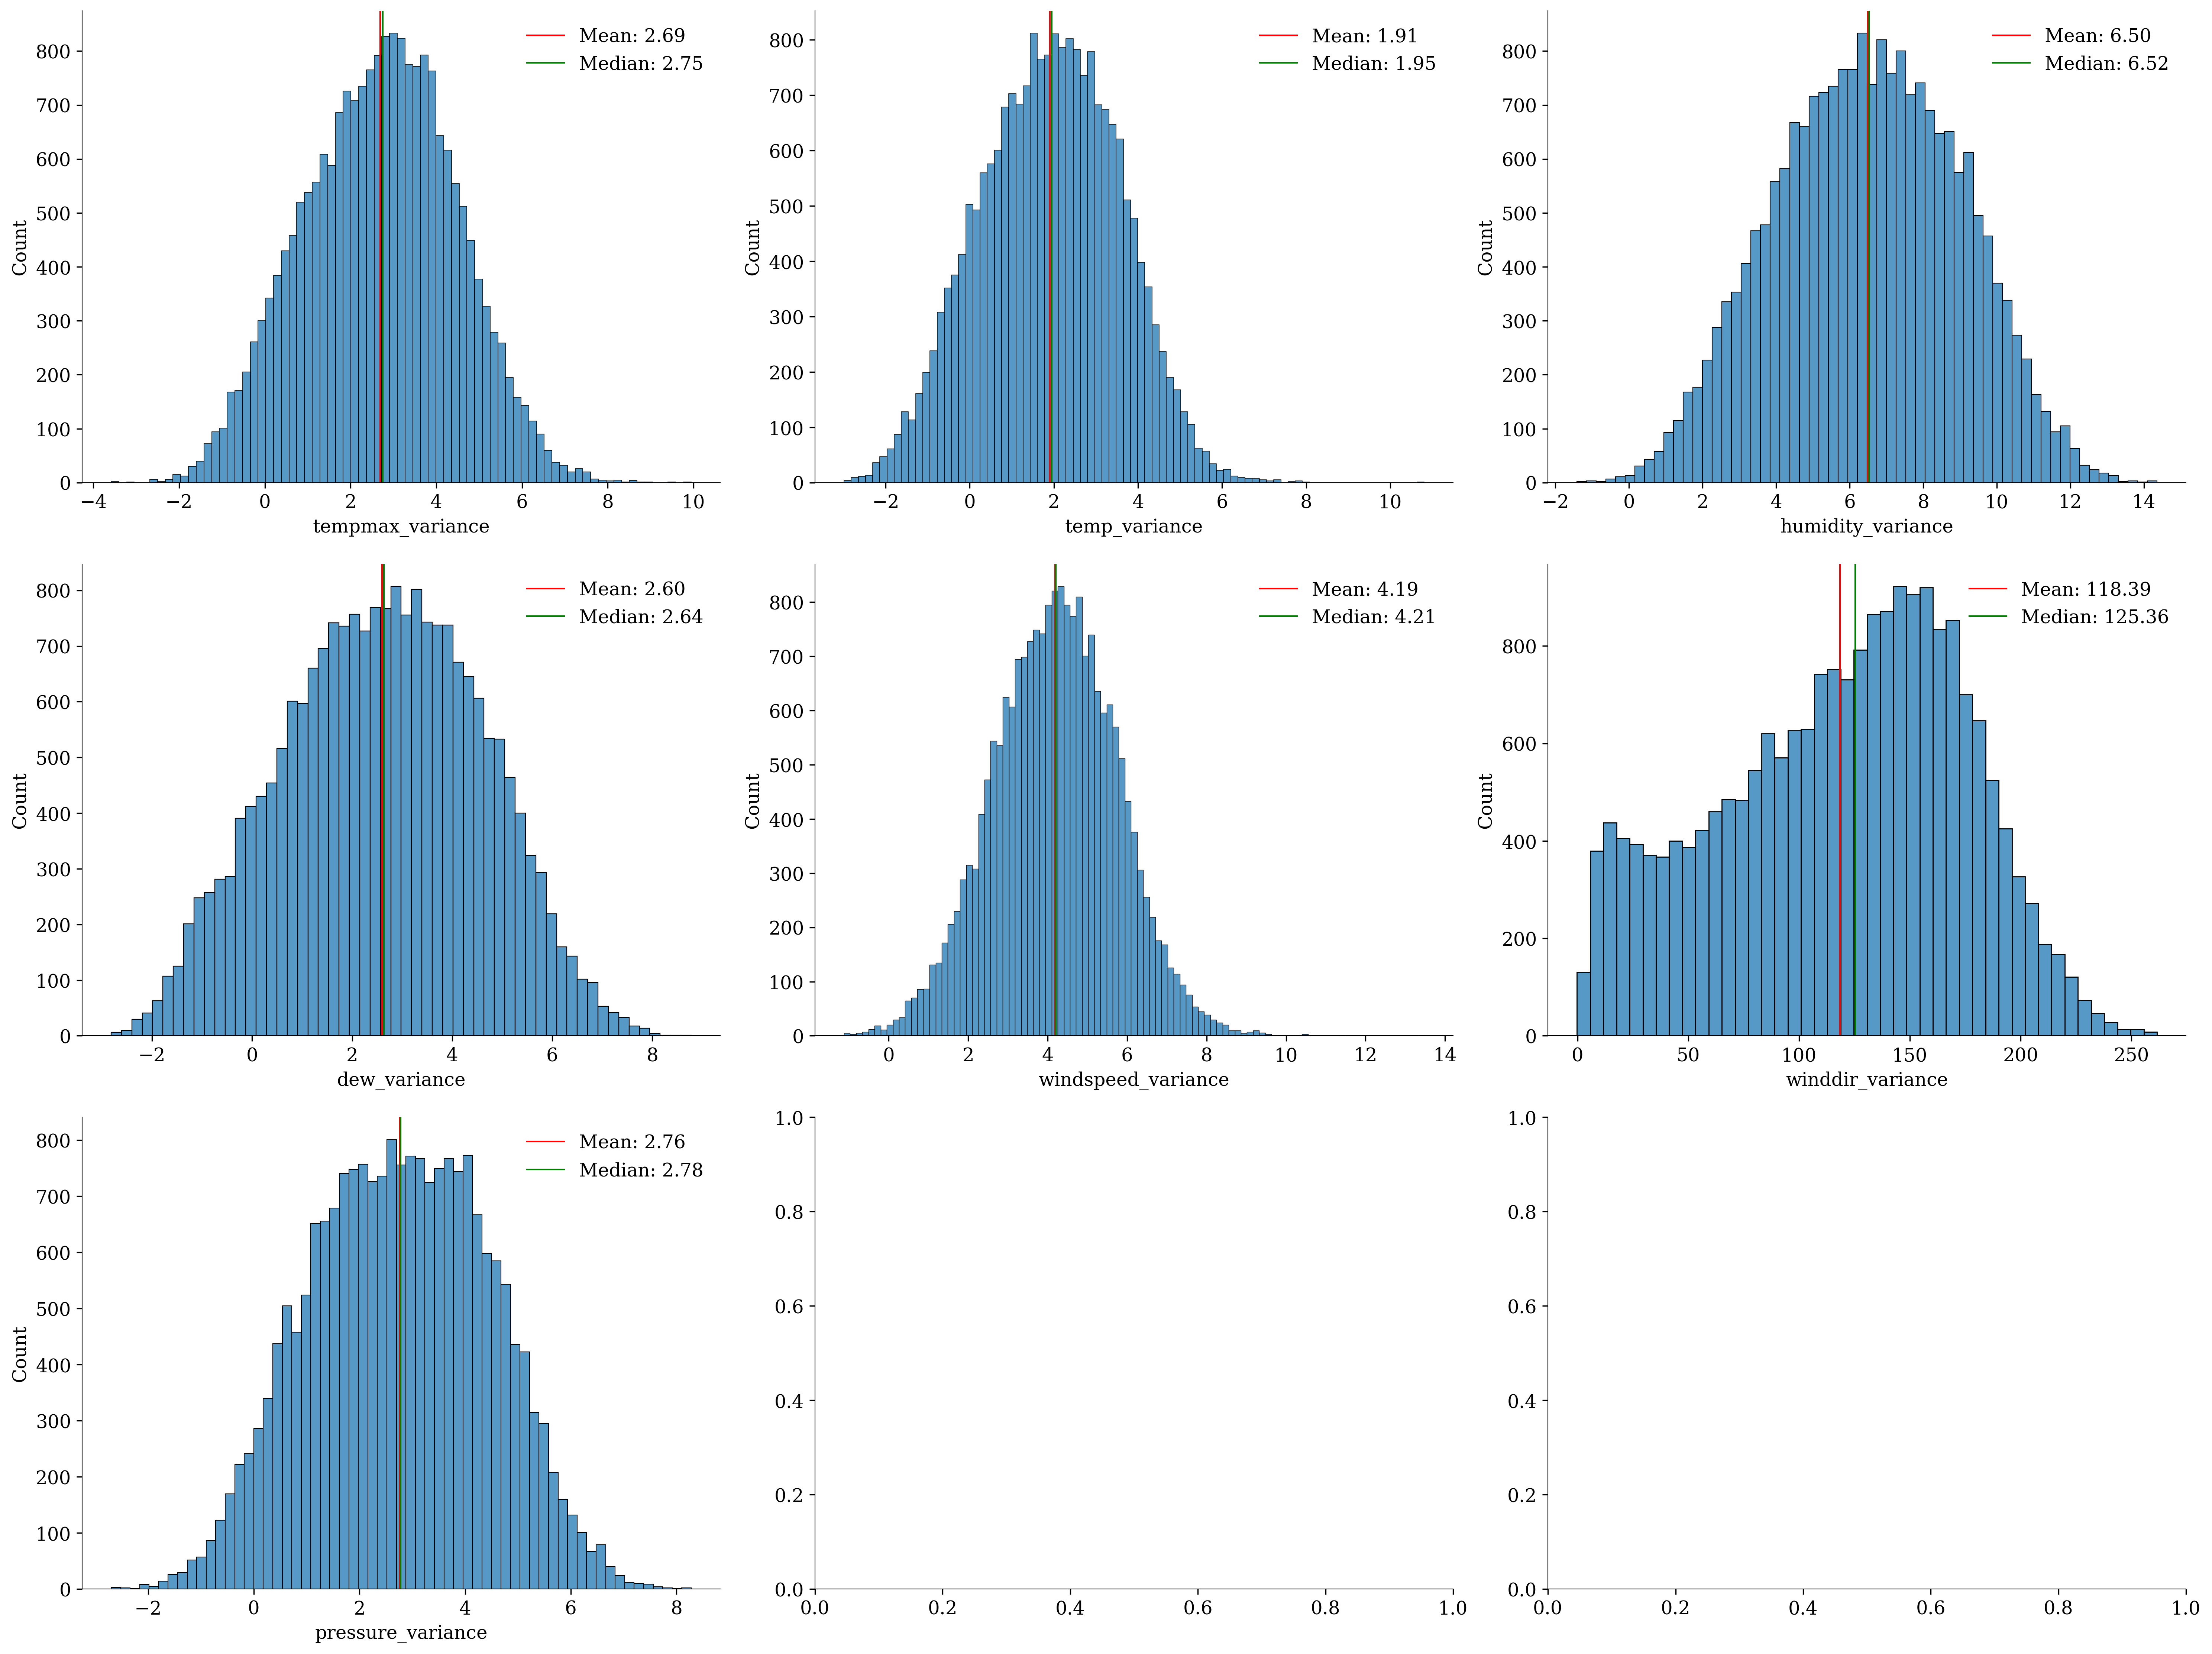

In [56]:
# Check transformations
utils.HistogramSubplots(numeric_df[boxcox_cols], figsize=(20, 15))

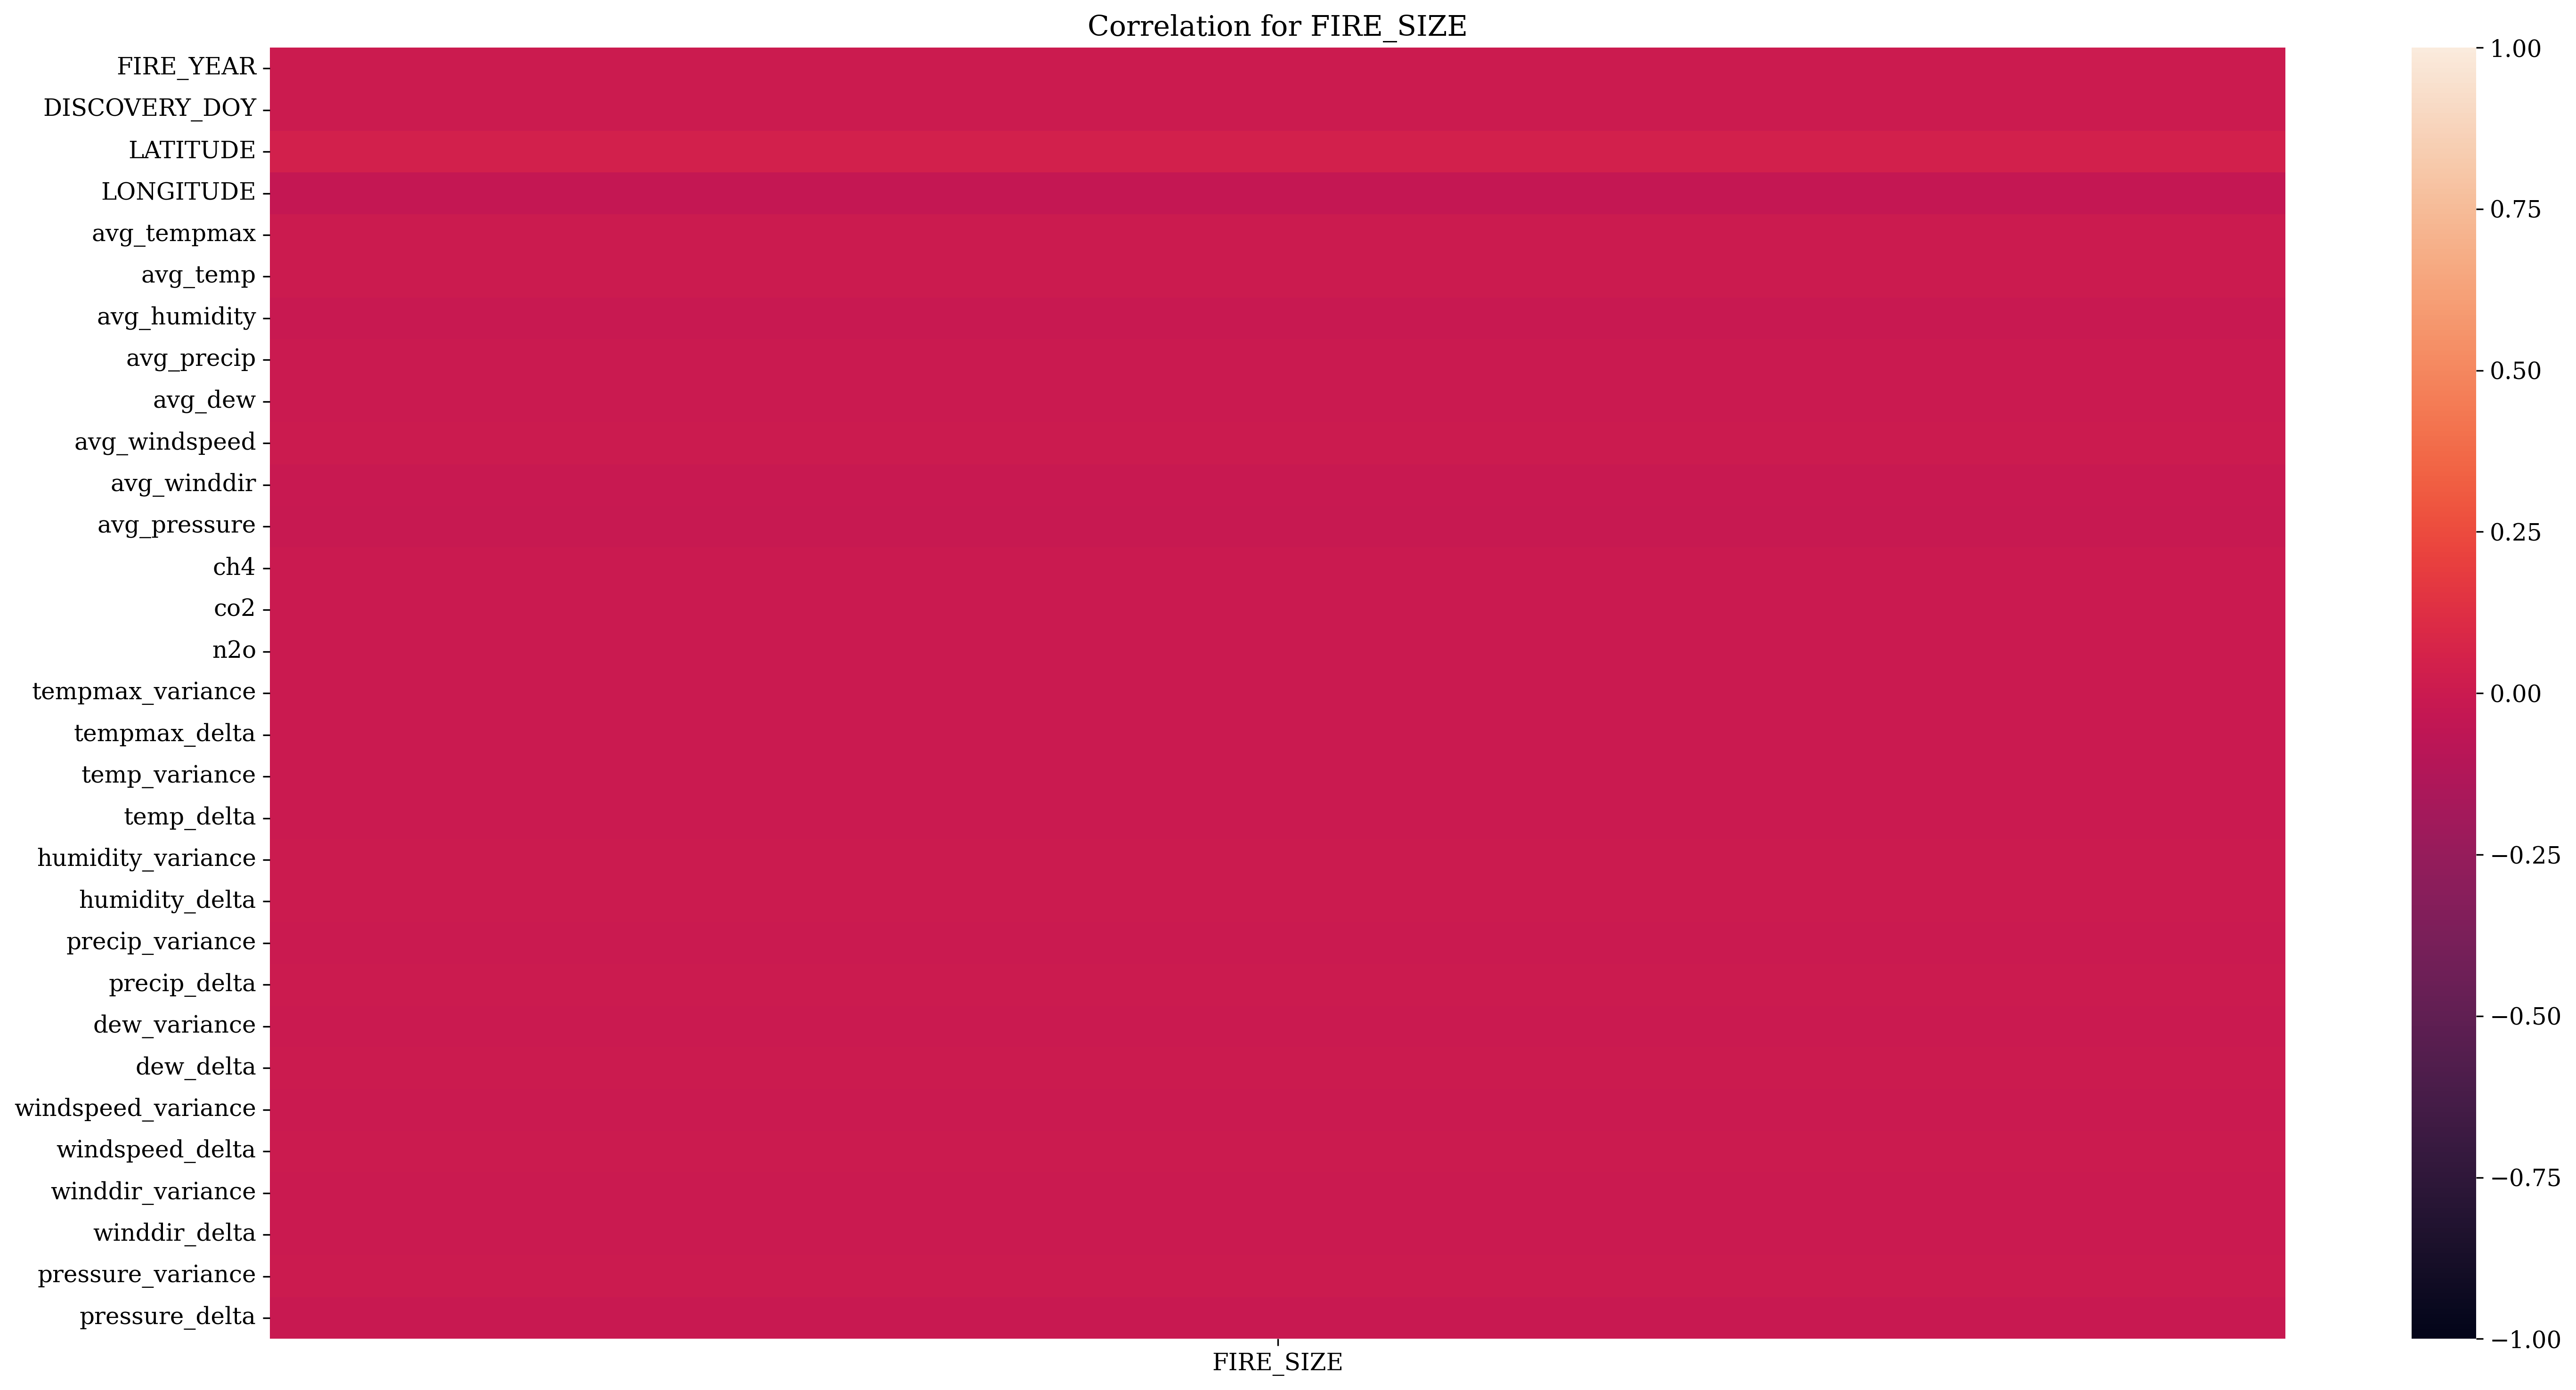

In [58]:
# Plot the correlation using a heatmap
corr = numeric_df.corr()
fire_size_corr = corr[['FIRE_SIZE']].drop('FIRE_SIZE', axis=0)

plt.figure(figsize=(20,10), dpi=300)
plt.title('Correlation for FIRE_SIZE')
sns.heatmap(fire_size_corr, vmin=-1, vmax=1)
plt.show()

Unfortunately, the transformation has not changed the correlation between these variables. We will now begin building a Linear Regression model, although we can predict that this will not yield positive results. 

<a id='model_building'></a>
### Model Building

In [59]:
df_processed = pd.concat([numeric_df, categorical_df], axis=1)
df_processed.head()

FIRE_YEAR  DISCOVERY_DOY  FIRE_SIZE   LATITUDE   LONGITUDE  avg_tempmax  \
0       1992              1       0.10  43.325000 -101.018500     5.257143   
1       1992              1       1.00  33.058333  -79.979167    13.700000   
2       1992              2       0.25  40.775000  -74.854160     6.385714   
3       1992              3       1.91  31.018500  -83.297300    14.457143   
4       1992              3       2.00  30.728900  -87.238100    14.428571   

    avg_temp  avg_humidity  avg_precip   avg_dew  ...  state_SD  state_TN  \
0  -2.928571     81.142857    0.000000 -6.071429  ...         1         0   
1   9.885714     81.428571    4.185714  6.671429  ...         0         0   
2   1.585714     67.185714    1.394286 -4.242857  ...         0         0   
3  11.828571     78.957143    4.685714  8.128571  ...         0         0   
4  10.985714     79.971429    0.188571  7.500000  ...         0         0   

   state_TX  state_UT  state_VA  state_VT  state_WA  state_WI  state_WV  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   state_WY  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 86 columns]

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = df_processed.drop(['FIRE_SIZE', 'FIRE_SIZE_CLASS', 'FIRE_SIZE_NUMERIC'], axis=1)
y = df_processed['FIRE_SIZE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [66]:
base_linreg = LinearRegression()
base_linreg.fit(X_train, y_train)

print(f'The TEST score for the base model is: {base_linreg.score(X_test, y_test)}')

The TEST score for the base model is: -0.8178368833415663


We see that this model performs very poorly. In order to improve the model, we can transform the columns. Columns which are heavily skewed, such as the precipitation variance and the emissions features, will be scaled using a Robust Scaler. Normally distributed features, on the other hand, will be scaled with a Standard Scaler, while those features that are relatively evenly distributed will be scaled with a MinMax Scaler.

In [67]:
# Create the scaling columns
robust_cols = ['precip_variance', 'ch4', 'n2o', 'co2']
minmax_cols = ['FIRE_YEAR', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE']
state_cols = [col for col in X_train.columns
              if 'state' in col]
ss_cols = [col for col in X_train.columns
           if col not in robust_cols
           if col not in minmax_cols
           if col not in state_cols]

Now that we have created these lists, we can create a column transformer that converts these columns using the appropriate scaler.

In [69]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Create column transformation list
col_transforms = [('standard scale', StandardScaler(), ss_cols),
                  ('minmax scale', MinMaxScaler(), minmax_cols), 
                  ('robust scale', RobustScaler(), robust_cols)]

# Create the column transformer
col_transformer = ColumnTransformer(col_transforms, remainder='passthrough')

# Fit to X_train
col_transformer.fit(X_train);

In [70]:
# Transform the train and test set
X_train_transformed = col_transformer.transform(X_train)
X_test_transformed = col_transformer.transform(X_test)

In [71]:
# Create the Linear Regression with the transformed columns
linreg = LinearRegression()
linreg.fit(X_train_transformed, y_train);

Now that we have created a model we are able to make some predictions on our validation set.

In [72]:
print(f'Test score: {linreg.score(X_test_transformed, y_test)}')

Test score: -0.8178369962090901


<a id='evaluation'></a>
### Baseline Model Evaluation

The model continues to perform as poorly as before we carried out any scaling, generating a negative $R^2$ value. Let us take a look at the coefficients to see how these influenced the predictions of the model.

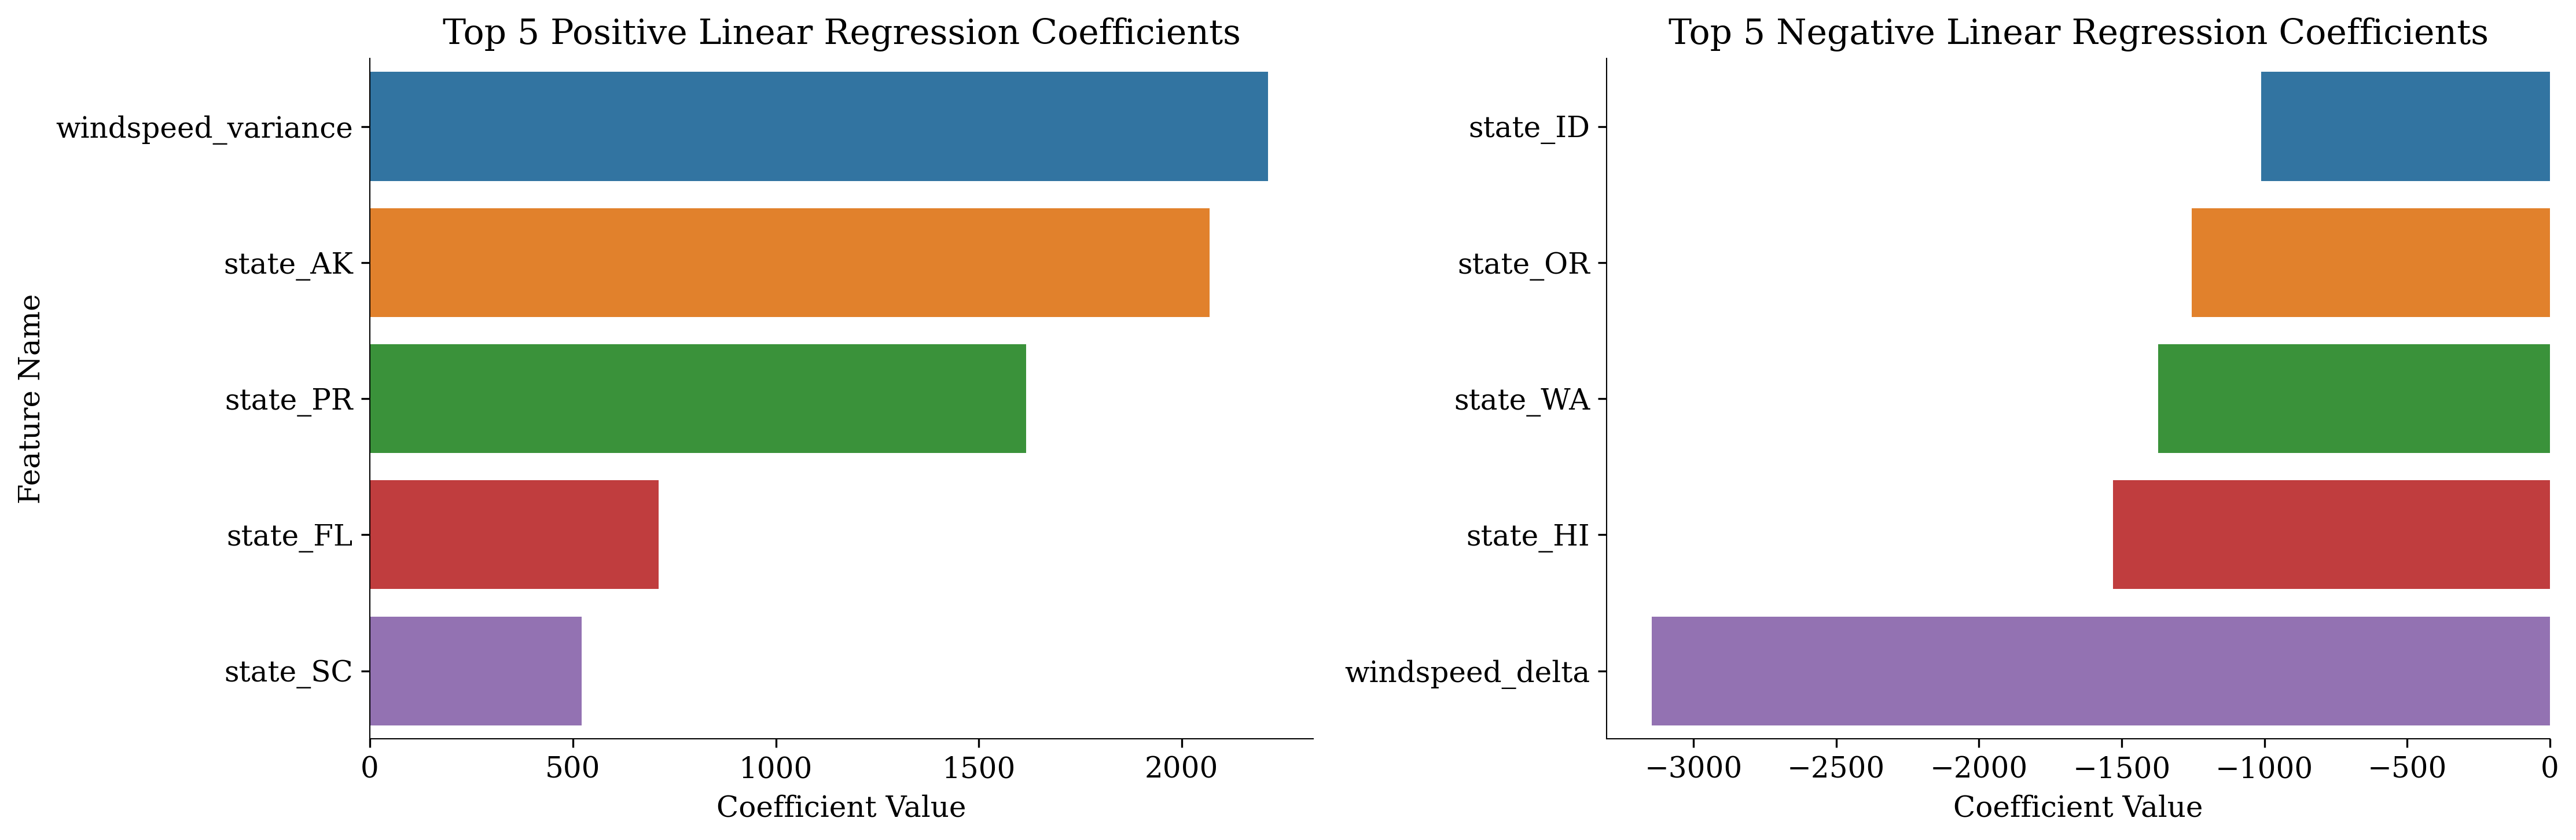

In [73]:
# The coefficient, notice it returns an array with one spot for each feature
coefficients = linreg.coef_

coefficients_df = pd.DataFrame(data={'coef':coefficients}, index=X.columns).sort_values(by='coef', ascending=False)

plt.subplots(1, 2, figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Top 5 Positive Linear Regression Coefficients')
sns.barplot(x='coef', y=coefficients_df.head().index, data=coefficients_df.head())
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')

plt.subplot(1, 2, 2)
plt.title('Top 5 Negative Linear Regression Coefficients')
sns.barplot(x='coef', y=coefficients_df.tail().index, data=coefficients_df.tail())
plt.xlabel('Coefficient Value')
plt.show()

From the graphs of the coefficients we see that the fire size is largely determined by location. Windspeed variance and the change in windspeed, additionally contributed heavily in alternate directions. We see though, from the scale of the coefficient values, that these variables are not good predictors of wildfire size and we can see from other metrics, such as Mean Absolute Error (MAE) and Root Mean Squared Errror (RMSE), that the model performed poorly.

In [74]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

y_pred = linreg.predict(X_test_transformed)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred)}')

MAE: 179.87799881850805
RMSE: 449156.1170515191


<a id='improvement'></a>
### Model Improvement

One of the potential ways in which we can improve our model is by using less features and reducing any multicollinearity that might be present in the model. In terms of multicollinearity, we see from the correlation plot, that many of the features that we are using are highly correlated. This is not surprising considering that weather features tend to correlate. Additionally, any features that we have created are values that are derived from the collected weather data - invariably, these features will also be highly correlated. We can determine the most valuable features from a linear model by using a variety of methods. Methods include Lasso and Ridge regression which penalise the optimisation functions of the models. To begin, we will use a Lasso Regression to determine the most important features

In [78]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_score

alphas = np.linspace(1, 50, 50)

cross_val_scores = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    cv_score = np.mean(cross_val_score(lasso, X_train_transformed, y_train, cv = 5))
    cross_val_scores.append(cv_score)

Using a higher alpha increases the penalty, which means features are removed if they are not contributing sufficiently to the model. 

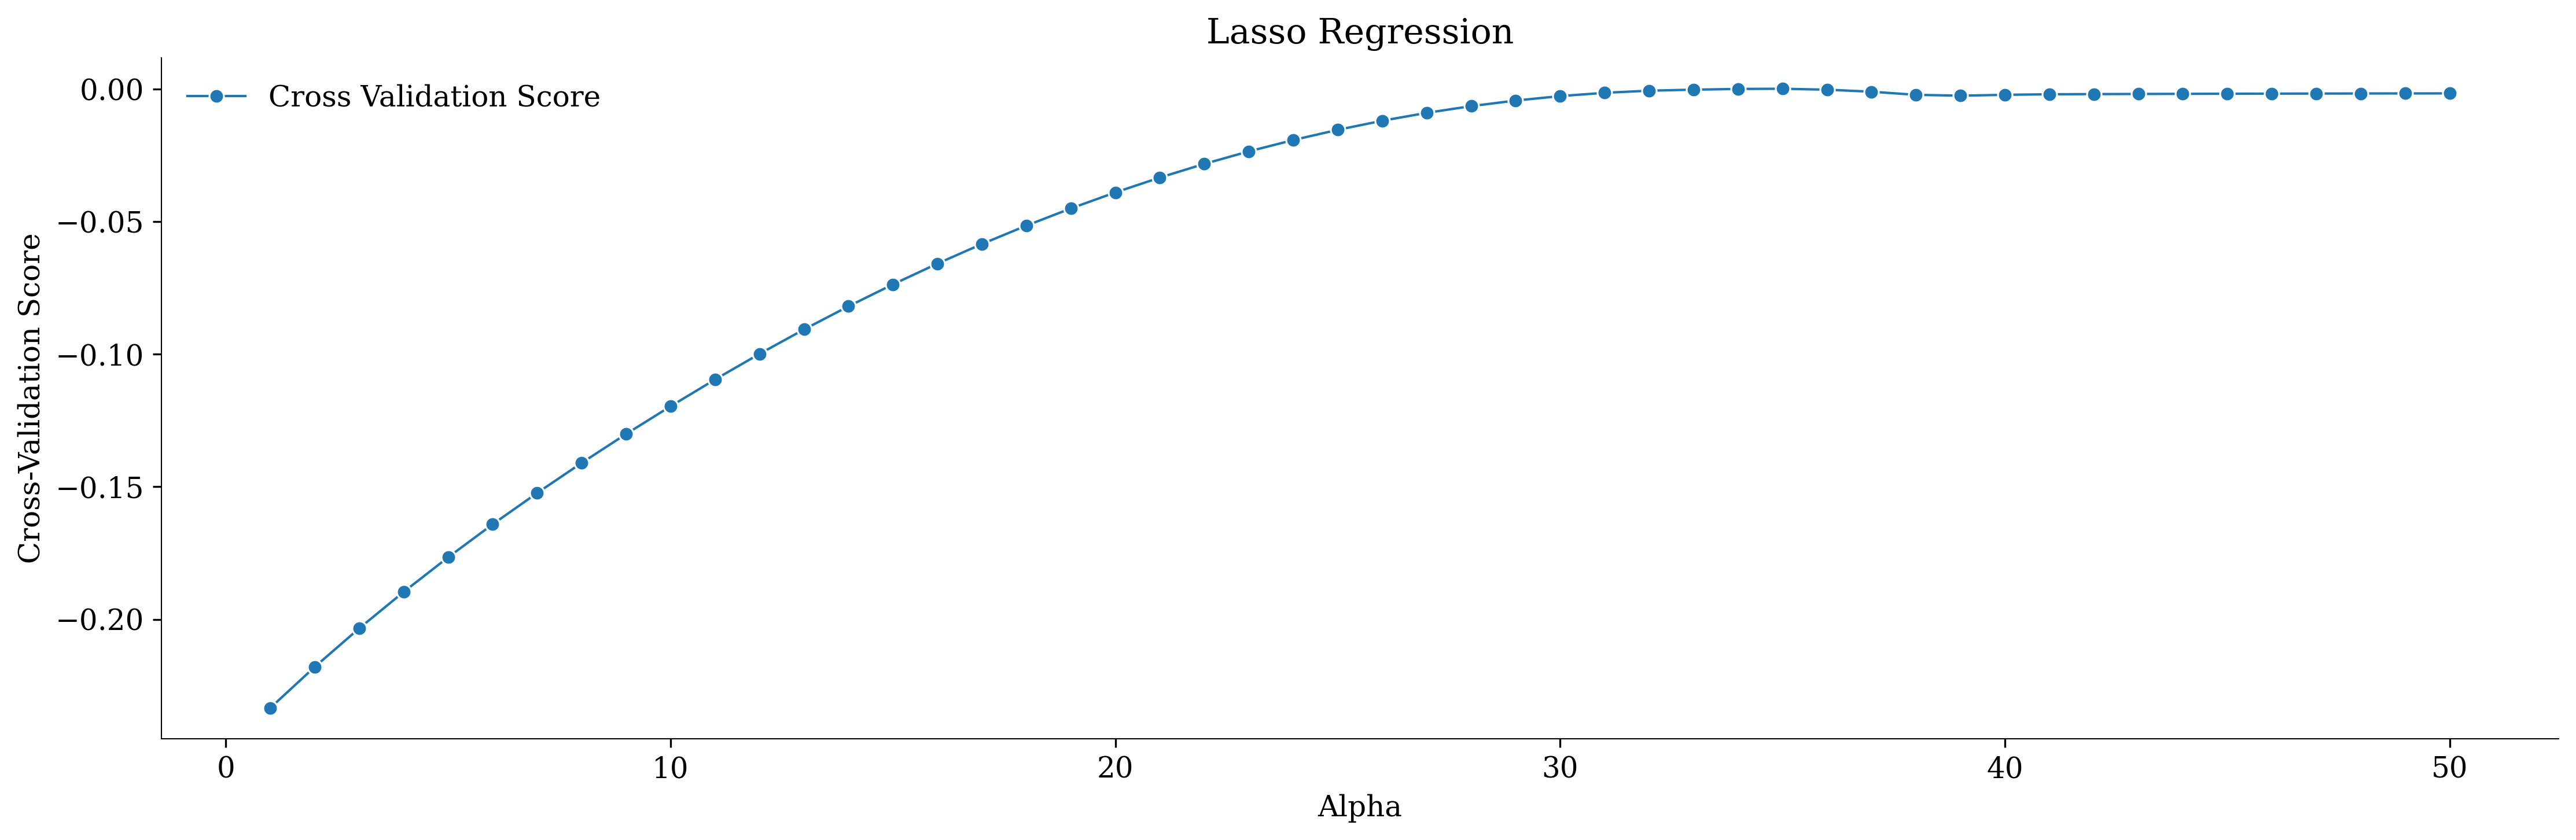

In [79]:
plt.figure(figsize=(15, 5))
plt.title('Lasso Regression')
sns.lineplot(x=alphas, y=cross_val_scores, marker='o', label='Cross Validation Score')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation Score')
plt.show()

We see then, as the alpha increases, that the models' $R^2$ values increase as redundant columns are removed. With very high alpha values, we see that the model tends towards a cross validation score of 0. We can see the alpha value that generated the highest cross validation score and see the features that determined this.

In [84]:
print(f'The alpha that generated the highest validation score was: {alphas[np.argmax(cross_val_scores)]}')
print(f'This generated an score of: {max(cross_val_scores):.4f}')

The alpha that generated the highest validation score was: 35.0
This generated an score of: 0.0001


In [86]:
lasso_df = model_utils.ridge_lasso_evaluation(Lasso, X_train, y_train, alphas)
plt.figure(figsize=(30, 30))
sns.heatmap(lasso_df)
plt.show()

As in the previous model, we see that the only values that contributed to the model were geographic. Even in this instance this isn't an insightful realisation, neither is it specific - Alaska has a high proportion of large wildfires, meaning that if a wildfire is located in Alaska, there is a higher probability that it is going to be larger. 

We also mentioned previously that there is another method of regularisation - Ridge Regression. Unlike the Lasso Regression this is going to reduce the coefficients of features rather than setting them to 0. We can therefore gain a better understanding of the way in which features interact. 

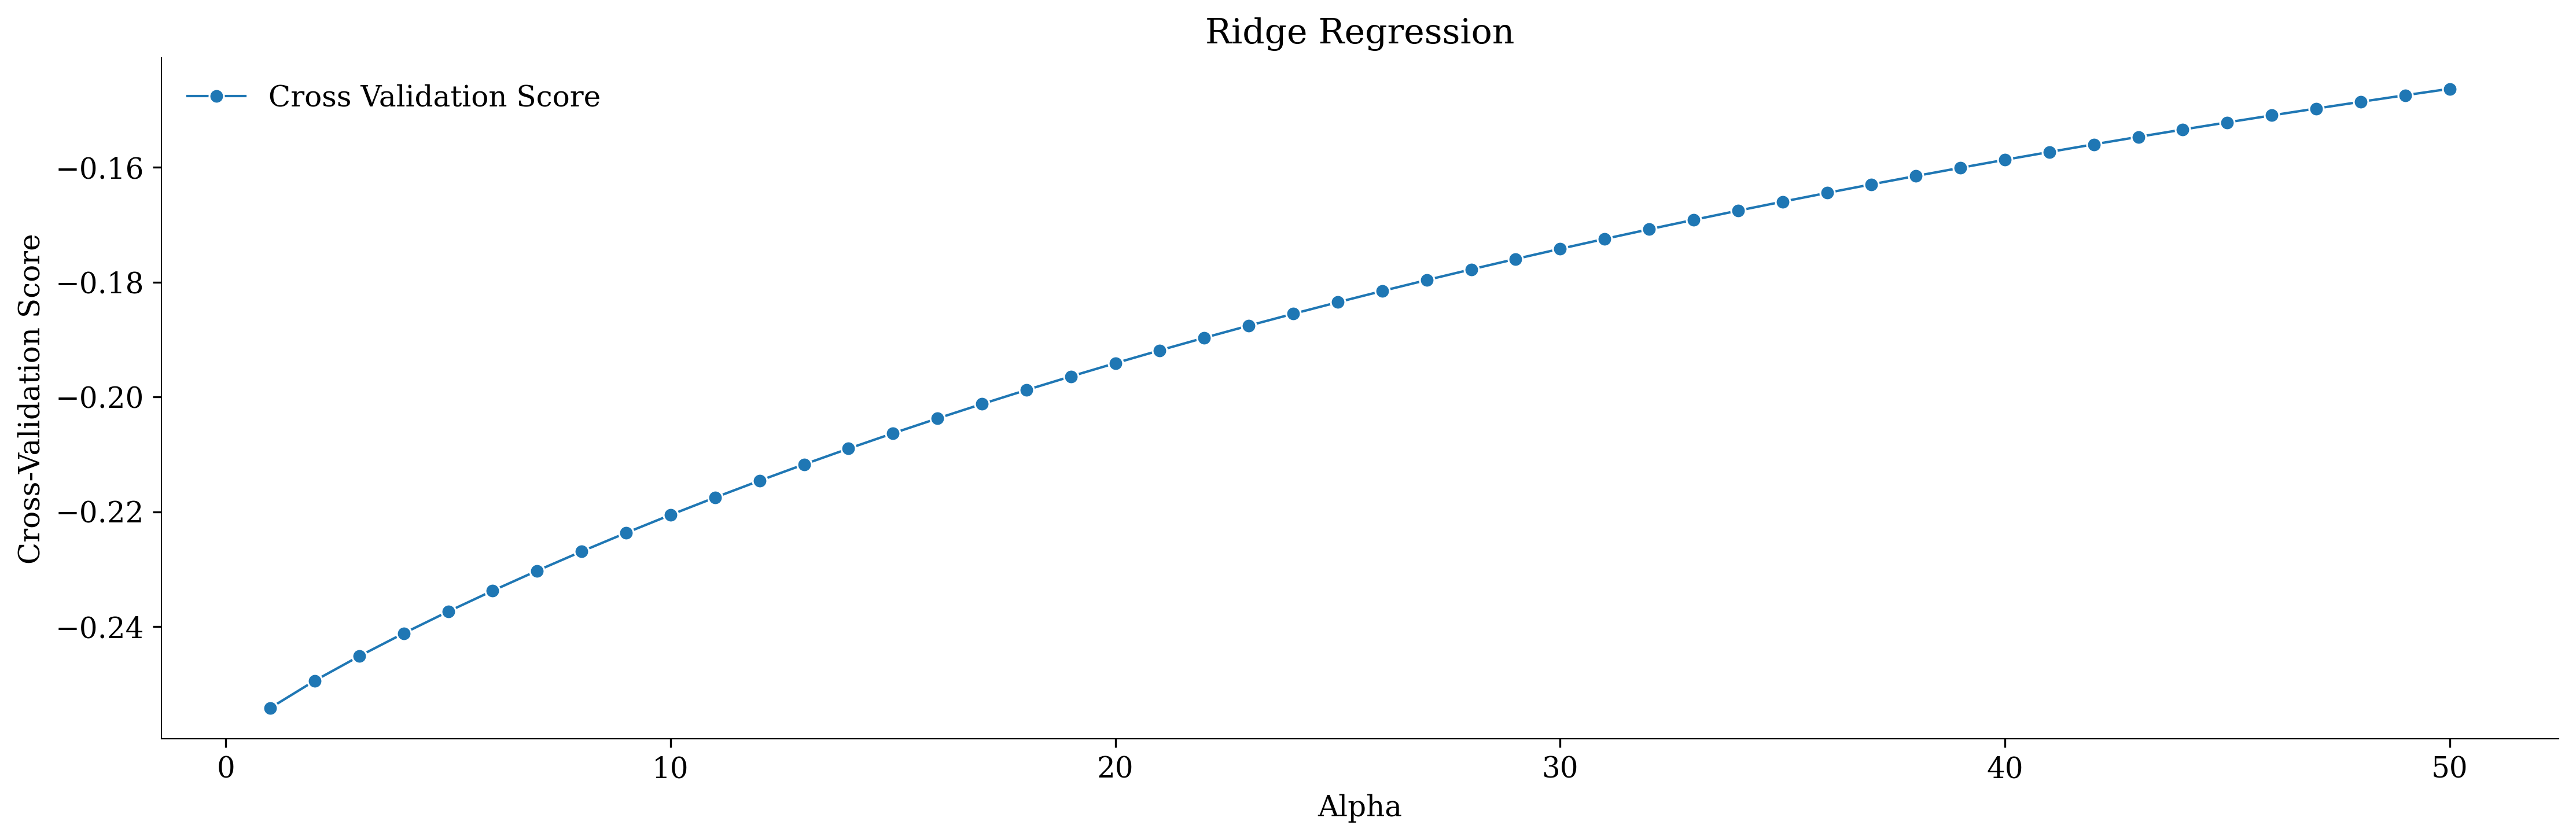

In [87]:
cross_val_scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    cv_score = np.mean(cross_val_score(ridge, X_train, y_train, cv = 5))
    cross_val_scores.append(cv_score)
    
plt.figure(figsize=(15, 5), dpi=300)
plt.title('Ridge Regression')
sns.lineplot(x=alphas, y=cross_val_scores, marker='o', label='Cross Validation Score')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation Score')
plt.show()

We see that in this case, because the features are never fully removed, we have generally less accurate models.

In [88]:
ridge_df = model_utils.ridge_lasso_evaluation(Ridge, X_train, y_train, alphas)

plt.figure(figsize=(30, 30))
sns.heatmap(ridge_df)
plt.show()

Once again, we see that the state in which the fire is located is going to heavily influence the accuracy of the model. Other features seemingly have no affect on the outcome of the models.

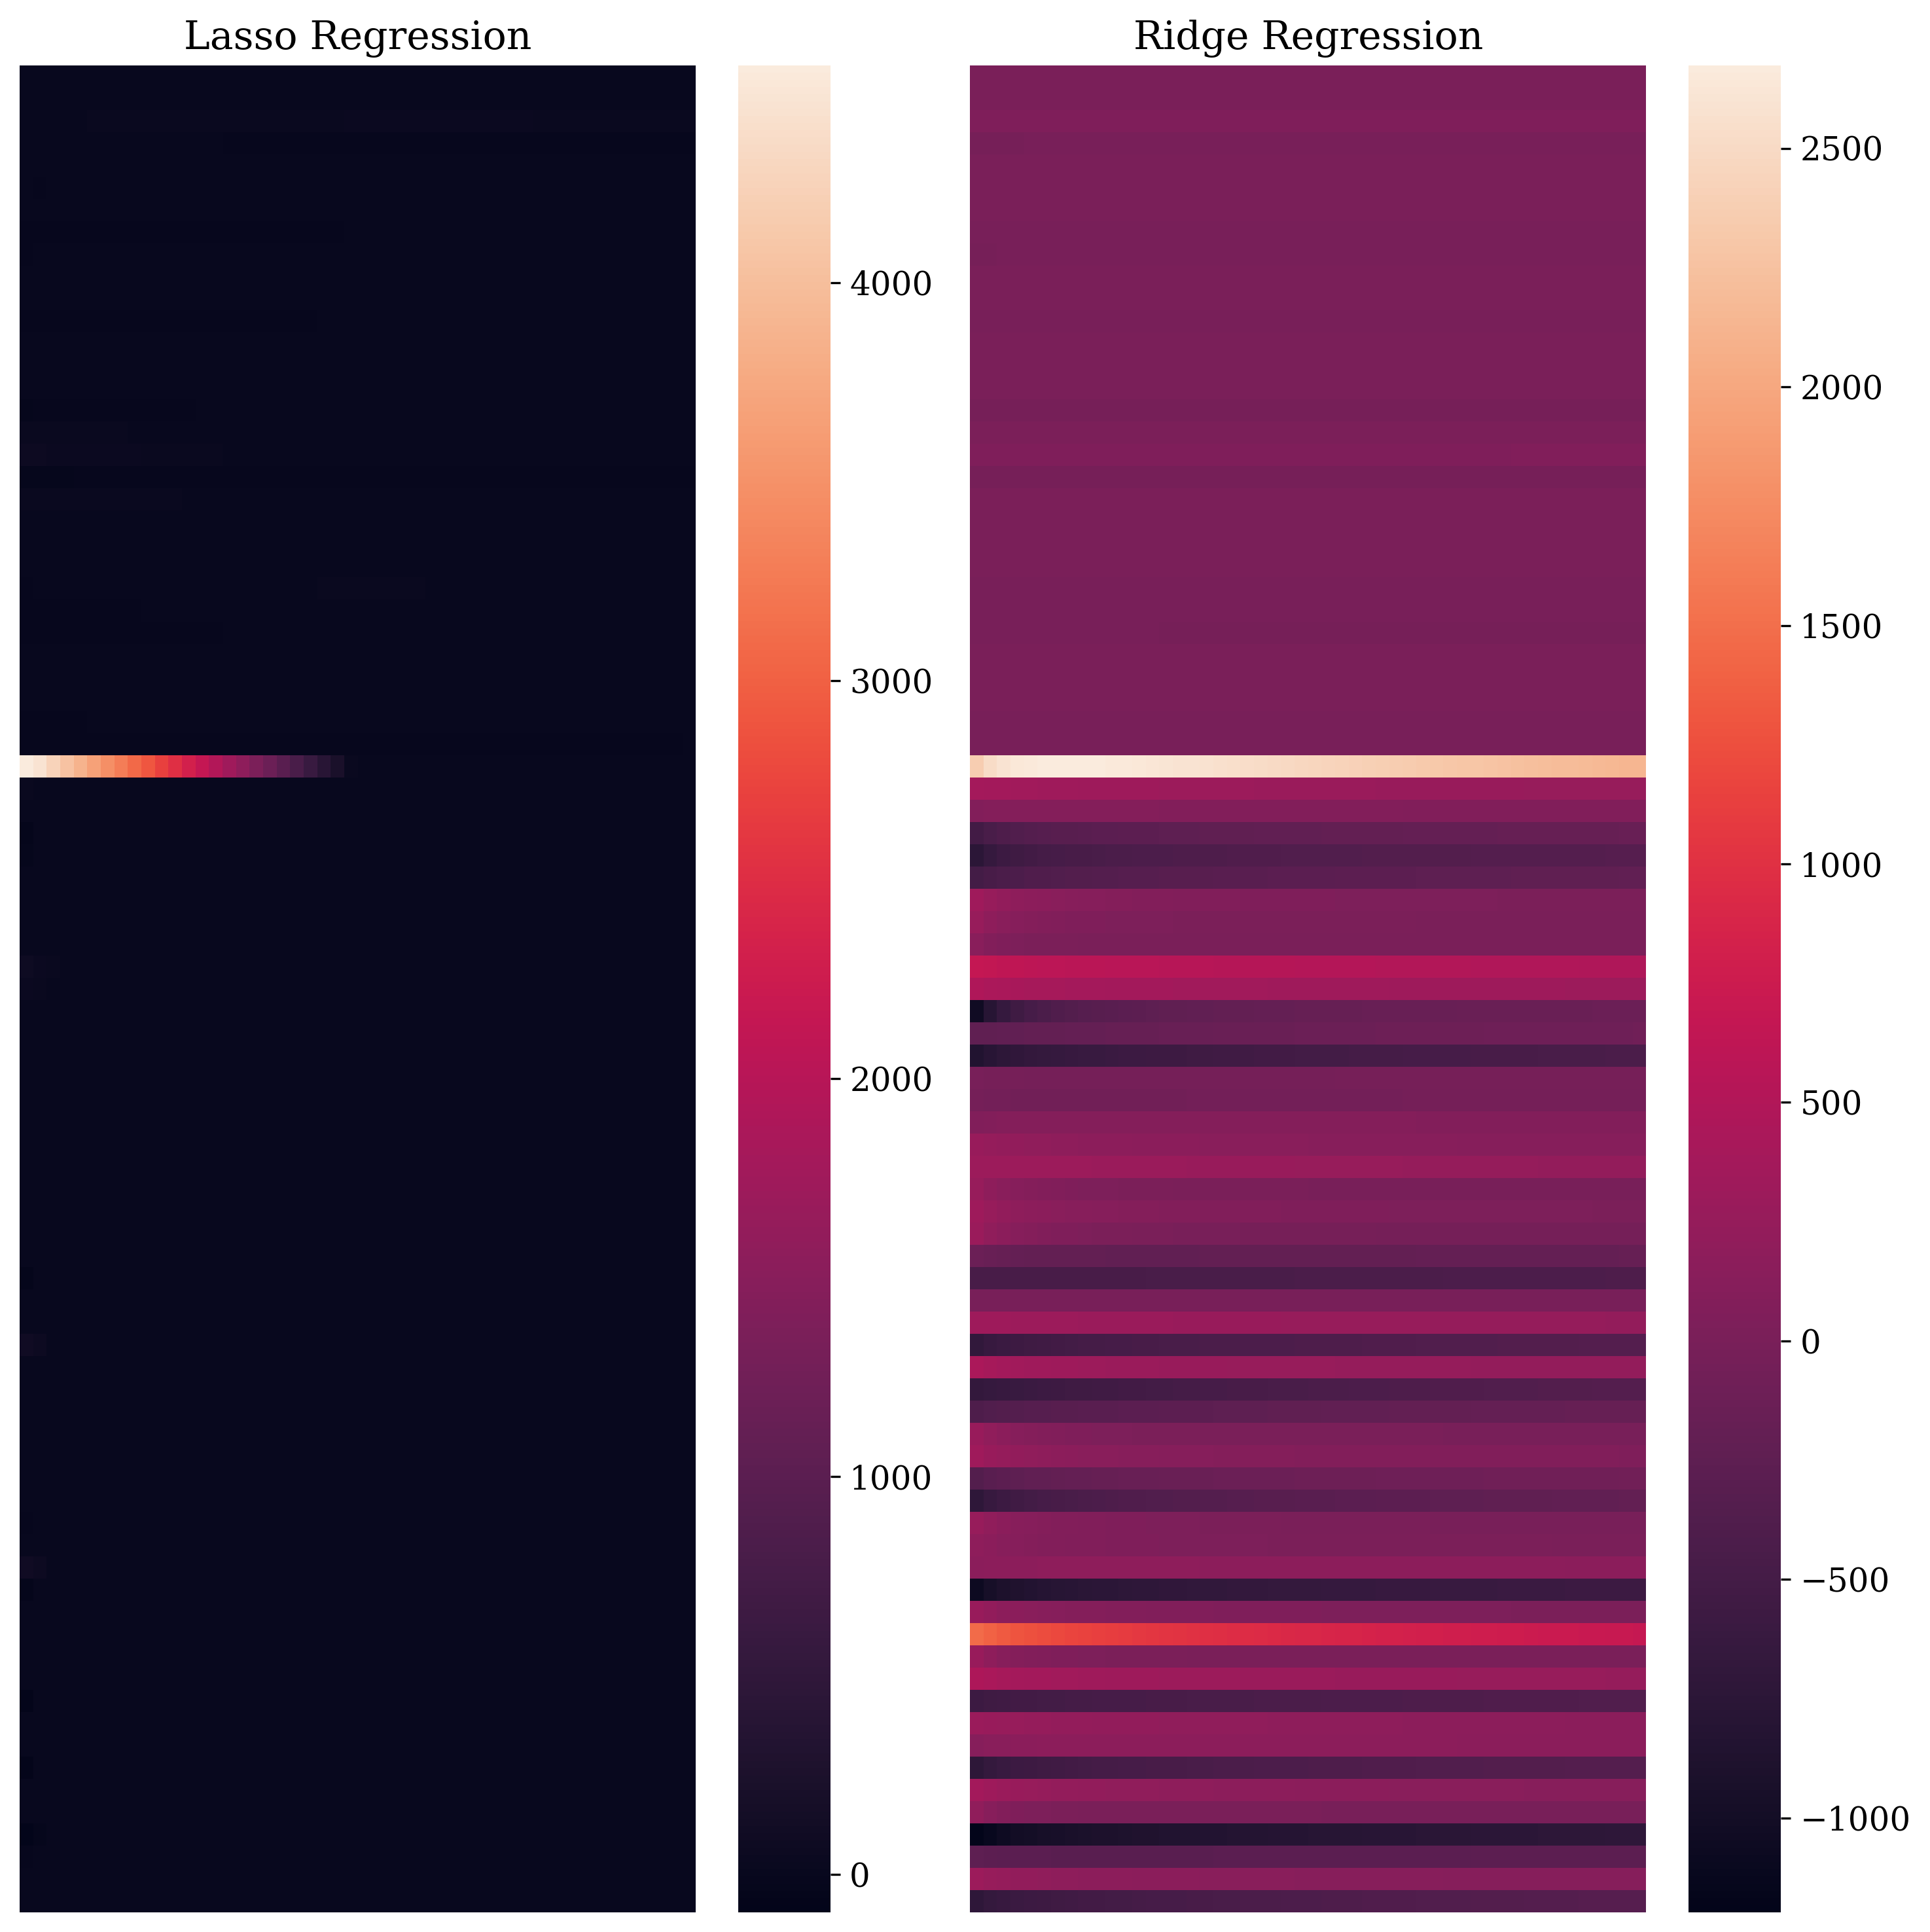

In [92]:
# Comparison of the models
plt.subplots(1, 2, figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title('Lasso Regression')
sns.heatmap(lasso_df)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Ridge Regression')
sns.heatmap(ridge_df)
plt.axis('off')
plt.show()

---
<a id='base_logreg'></a>
## Baseline Logistic Regression

Having been unsuccessful in creating a Linear Regression model, we can perhaps build a logistic regression model that classifies a fire size into one of the 7 classes. The accuracy for this model, invariably, will be much larger considering the distributions of the classes. 

In [94]:
X = df_processed.drop(['FIRE_SIZE', 'FIRE_SIZE_CLASS', 'FIRE_SIZE_NUMERIC'], axis=1)
y = df_processed['FIRE_SIZE_CLASS']

utils.count_percentage_df(y)

Count  Percentage of Total
B  10529             0.504964
A   7355             0.352741
C   2441             0.117069
D    299             0.014340
E    140             0.006714
F     56             0.002686
G     31             0.001487

As we can see, over 50% of the fires fall within fire class B, meaning that a dummy model that always predicts a fire to belong to class B, will be correct 50% of the time. 

With this in mind, let us begin building the model.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

In [97]:
X_train_transformed = col_transformer.transform(X_train)
X_test_transformed = col_transformer.transform(X_test)

In [98]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_transformed, y_train)

LogisticRegression(max_iter=10000)

In [99]:
logreg.score(X_test_transformed, y_test)

0.5914648765284104

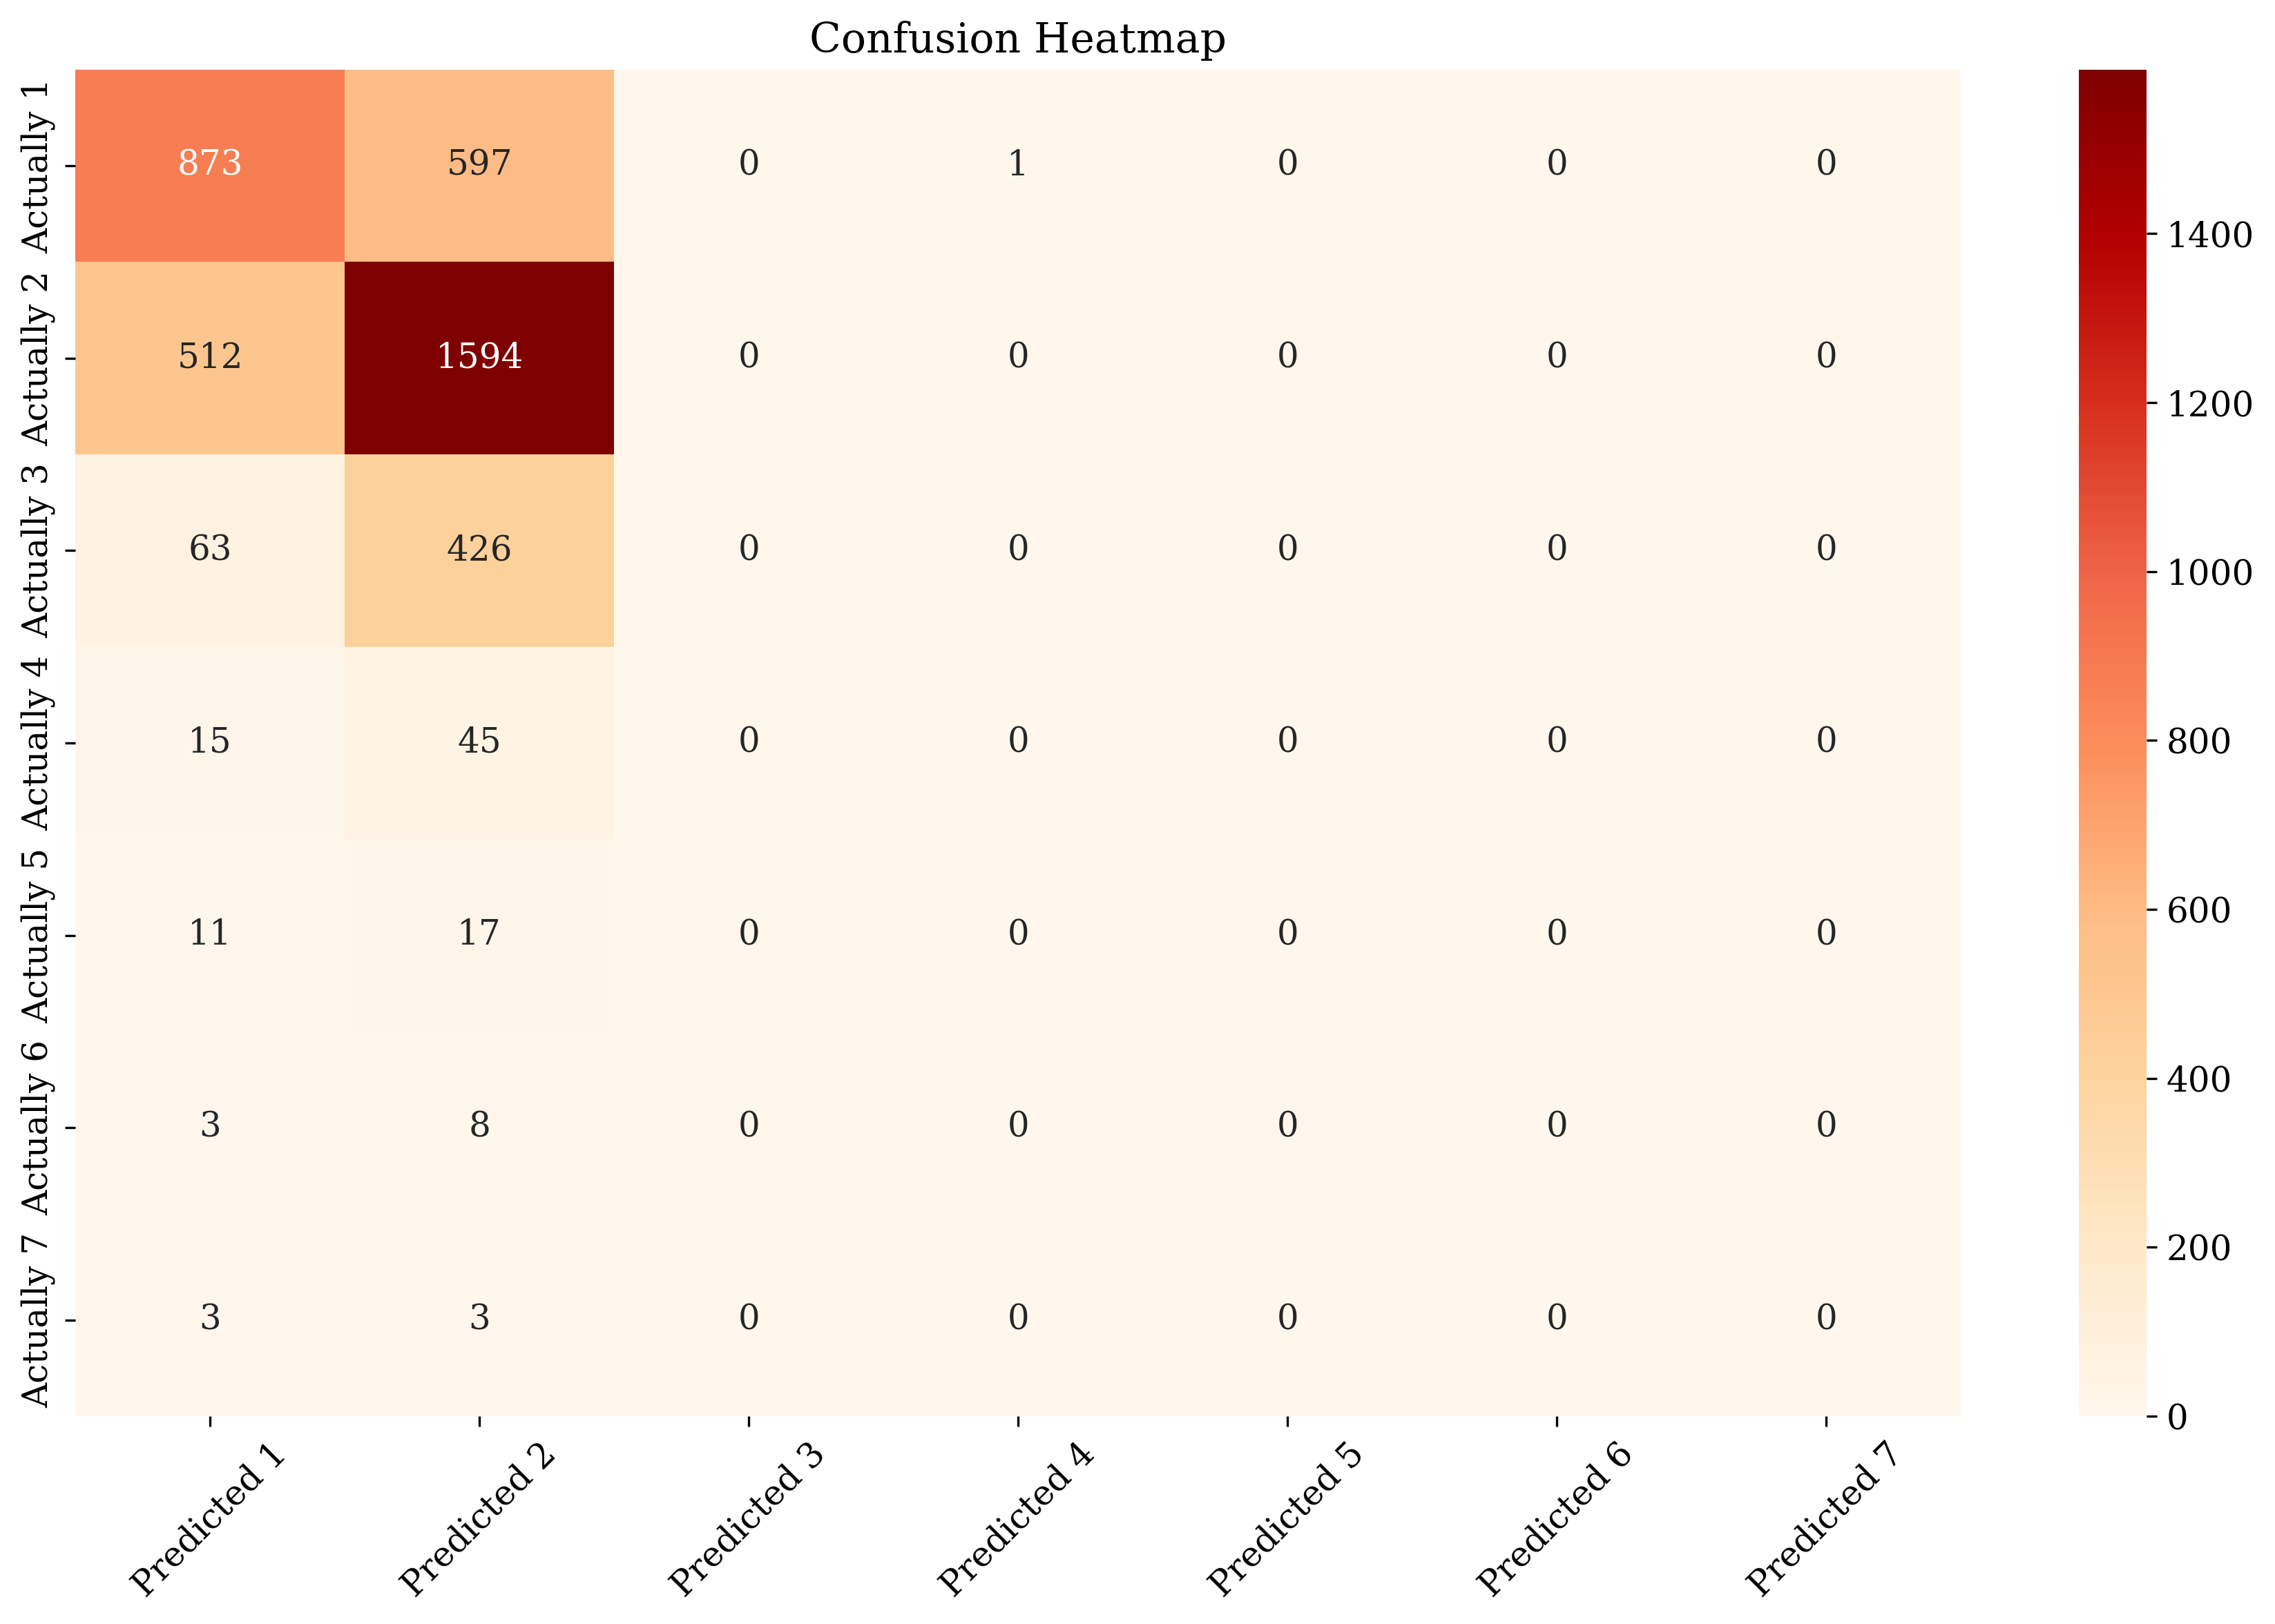

In [101]:
from sklearn.metrics import confusion_matrix

# Make classifications based on the test features, and assign the classifications to a variable
y_pred = logreg.predict(X_test_transformed)

predictions = y_test.unique()
predictions.sort()

# Build the confusion matrix as a dataframe
confusion_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
confusion_df.index = [f'Actually {i}' for i in predictions]
confusion_df.columns = [f'Predicted {i}' for i in predictions]

# Heatmap of the above
plt.figure(figsize=(12, 8), dpi=300)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='OrRd') # Passing in fmt='d' prevents the counts from being displayed in scientific notation
plt.xticks(rotation=45)
plt.title('Confusion Heatmap')
plt.show()

Given the imbalance in the data, it is unsurprising that the model was better at predicting the smaller fires rather than the larger ones. It has become clear then that perhaps in order to improve both of the models created we will need to increase the size of the data that we have collected. The following notebook will therefore collect data from larger wildfires and append these observations to the ones that we have already collected.